### Applied Time Series Analysis - Final Project

Matthew Cheng, David Huang, Peter Woo

May 10th, 2021



# Overview



This project aims to successfully filter out sounds from different drums from a recording using R--serving as a sort of "transcription" program. We will be focusing on a simple scenario first by trying to distinguish the sounds of two drums being played at different rhythms in a single audio file. 

# Methodology

The basic breakdown of the steps is as follows: 

1.   First we will examine the audio recordings (with the same sampling rates for the different audio files) of the drums separately and identify the respective frequencies. Since pitch is determined by frequency (Physics, n.d.), this should be enough for us to tell the drums apart.
2.   Using our knowledge of the individual drums, we will then examine an audio recording of the two drums being played simultaneously. Using a filter, we will try to separate the two different sounds being played based off of their frequencies and spectral signatures.
3.   Once we have accomplished this, we will attempt to measure our success by comparing the output to what was expected based on the given input. Basically, inspect to see which beats the two different drums were played at to produce the audio file and then compare that with the output. If the two are the same, then we have succeeded. 



## Importing the data

The data used in this project is real data; audio samples from two different tom drums are recorded using an iPhone 7, and are imported as .mp3 files. 

The two drums have different pitches, which allow them to be distinguishable from each other to the human ear. The first two mp3 files are a recording of each individual drum played by itself, and the third mp3 file is a recording of a basic cadence using the two drums. It is important to note that the drums can play separately/individually, and together as well.

The recordings of the .mp3 files can be found in github with the low drum being d1.mp3, the high drum being d2.mp3, and both drums being ds.mp3.

This project uses 2 R packages, `tuneR` and `tswge`. A later analysis in the project uses `seewave` as well.

In [1]:
install.packages('tswge')
install.packages('tuneR', dependencies = TRUE)
install.packages('seewave')

library('tswge')
library('tuneR')
library('seewave')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘signal’, ‘PolynomF’, ‘waveslim’, ‘astsa’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘pastecs’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



For the more music-savvy, the cadence used in the audio sample with both drums is written in sheet music as the following: 

![score](https://github.com/matthewcheng13/DATA_330_Final_Project/raw/main/score.png)

To import the actual audio files:

In [2]:
drums.url <- 'https://github.com/matthewcheng13/DATA_330_Final_Project/raw/main/ds.mp3'
drum1.url <- 'https://github.com/matthewcheng13/DATA_330_Final_Project/raw/main/d1.mp3'
drum2.url <- 'https://github.com/matthewcheng13/DATA_330_Final_Project/raw/main/d2.mp3'

drums.file <- "/tmp/drums.mp3"
drum1.file <- "/tmp/drum1.mp3"
drum2.file <- "/tmp/drum2.mp3"

download.file(
  url = drums.url, 
  destfile = drums.file, 
  method = "auto")
download.file(
  url = drum1.url, 
  destfile = drum1.file, 
  method = "auto")
download.file(
  url = drum2.url, 
  destfile = drum2.file, 
  method = "auto")

drums.mp3 <- readMP3(drums.file)
drum1.mp3 <- readMP3(drum1.file)
drum2.mp3 <- readMP3(drum2.file)

In [3]:
# For drum 1

# Some summary statistics about our soundbite 
str(drum1.mp3)

# Check for the length of the soundbite in seconds 
drum1.num_samples <- length(drum1.mp3@left)
drum1.seconds <- drum1.num_samples / drum1.mp3@samp.rate 

cat('\n', 'The drum1 sound file is', drum1.seconds, 'seconds long.')

Formal class 'Wave' [package "tuneR"] with 6 slots
  ..@ left     : int [1:222336] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ right    : int [1:222336] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ stereo   : logi TRUE
  ..@ samp.rate: num 44100
  ..@ bit      : num 16
  ..@ pcm      : logi TRUE

 The drum1 sound file is 5.041633 seconds long.

In [4]:
# For drum 2

# Some summary statistics about our soundbite 
str(drum2.mp3)

# Check for the length of the soundbite in seconds 
drum2.num_samples <- length(drum2.mp3@left)
drum2.seconds <- drum2.num_samples / drum2.mp3@samp.rate 

cat('\n', 'The drum2 sound file is', drum2.seconds, 'seconds long.')

Formal class 'Wave' [package "tuneR"] with 6 slots
  ..@ left     : int [1:222336] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ right    : int [1:222336] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ stereo   : logi TRUE
  ..@ samp.rate: num 44100
  ..@ bit      : num 16
  ..@ pcm      : logi TRUE

 The drum2 sound file is 5.041633 seconds long.

In [5]:
# For both the drums

# Some summary statistics about our soundbite 
str(drums.mp3)

# Check for the length of the soundbite in seconds 
drums.num_samples <- length(drums.mp3@left)
drums.seconds <- drums.num_samples / drums.mp3@samp.rate 

cat('\n', 'The drums sound file is', drums.seconds, 'seconds long.')

Formal class 'Wave' [package "tuneR"] with 6 slots
  ..@ left     : int [1:580608] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ right    : int [1:580608] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ stereo   : logi TRUE
  ..@ samp.rate: num 44100
  ..@ bit      : num 16
  ..@ pcm      : logi TRUE

 The drums sound file is 13.16571 seconds long.

## Cleaning and plotting the data

To reduce the amount of computation required, we can pull out only the left channel and convert the sound array to floating point values between 1 and -1. 

In [6]:
# Pull out just the left channel
drum1.mono <- drum1.mp3@left

# Reduce the sound array
drum1.reduced <- (drum1.mono / 2^(drum1.mp3@bit - 1))

In [7]:
drum2.mono <- drum2.mp3@left
drum2.reduced <- (drum2.mono / 2^(drum2.mp3@bit - 1))

In [8]:
drums.mono <- drums.mp3@left
drums.reduced <- (drums.mono / 2^(drums.mp3@bit - 1))

We can now plot the data to see what the sound clips look like 

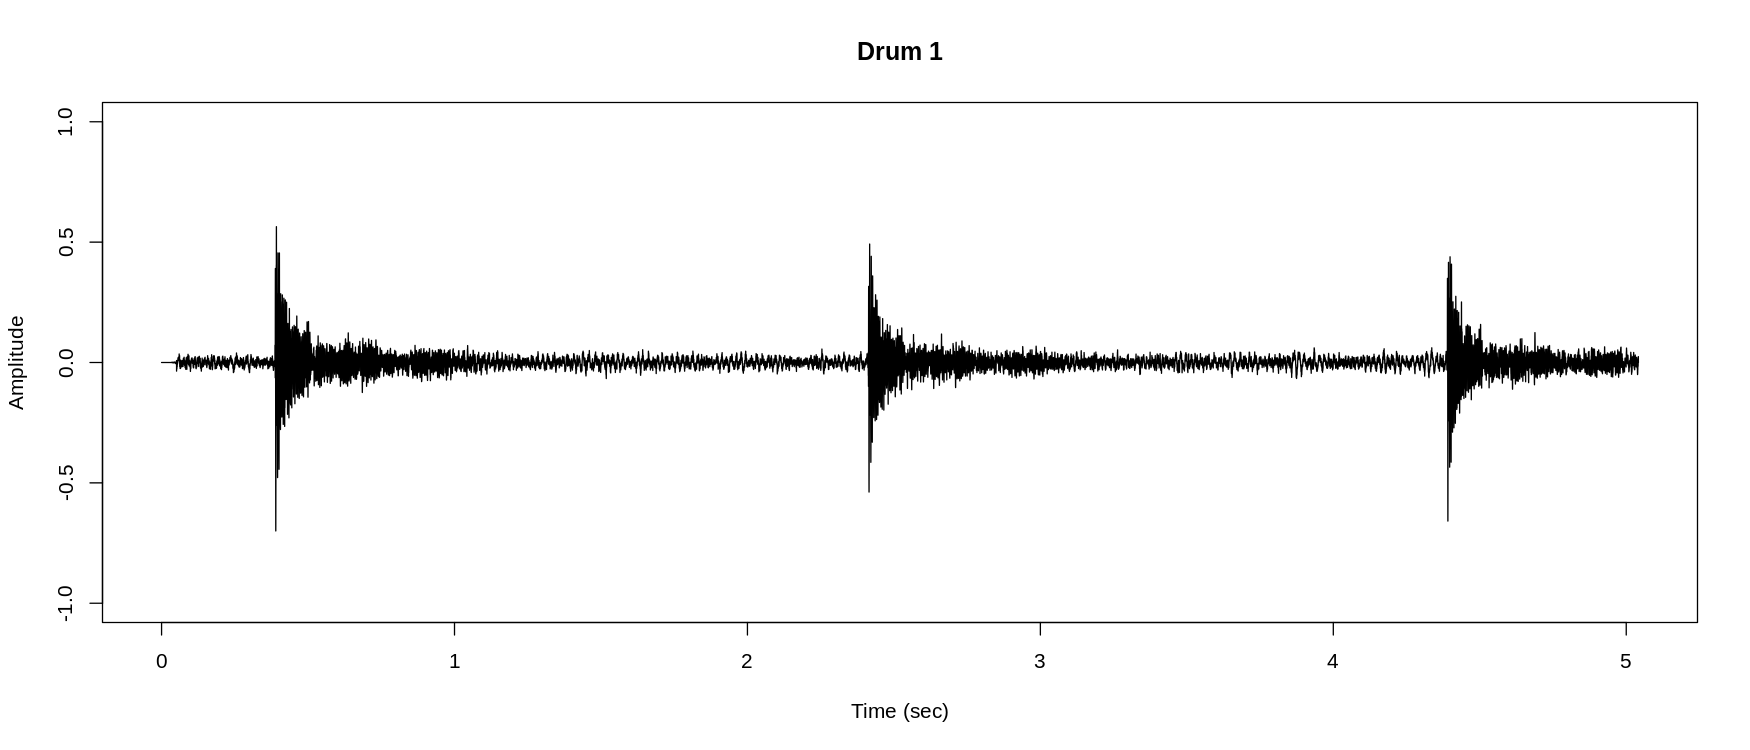

In [9]:
# For drum1; low drum

# Create an array with time points for the clip
drum1.time <- (0:(drum1.num_samples - 1)) / drum1.mp3@samp.rate

# Plot the sound file
options(repr.plot.width=14, repr.plot.height=6, repr.plot.res = 125)
plot(drum1.time, 
  drum1.reduced,
  ylim=c(-1.0,1.0),
  type='l', 
  col='black',
  main = 'Drum 1',  
  xlab='Time (sec)', 
  ylab='Amplitude')

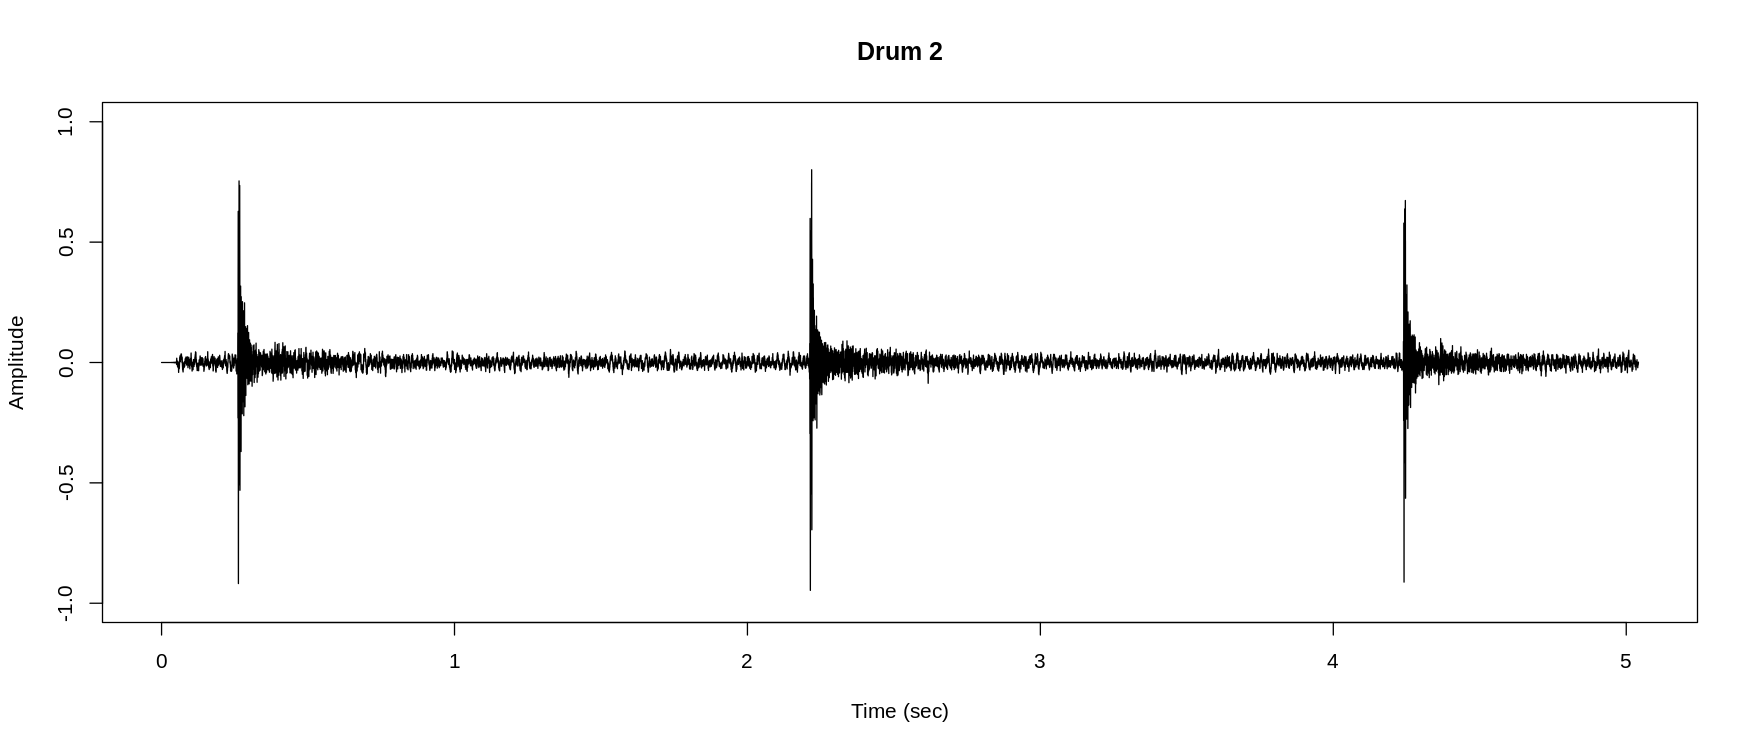

In [10]:
# For drum2; high drum

drum2.time <- (0:(drum2.num_samples - 1)) / drum2.mp3@samp.rate
options(repr.plot.width=14, repr.plot.height=6, repr.plot.res = 125)
plot(drum2.time, 
  drum2.reduced,
  ylim=c(-1.0,1.0),
  type='l', 
  col='black',
  main = 'Drum 2',  
  xlab='Time (sec)', 
  ylab='Amplitude')

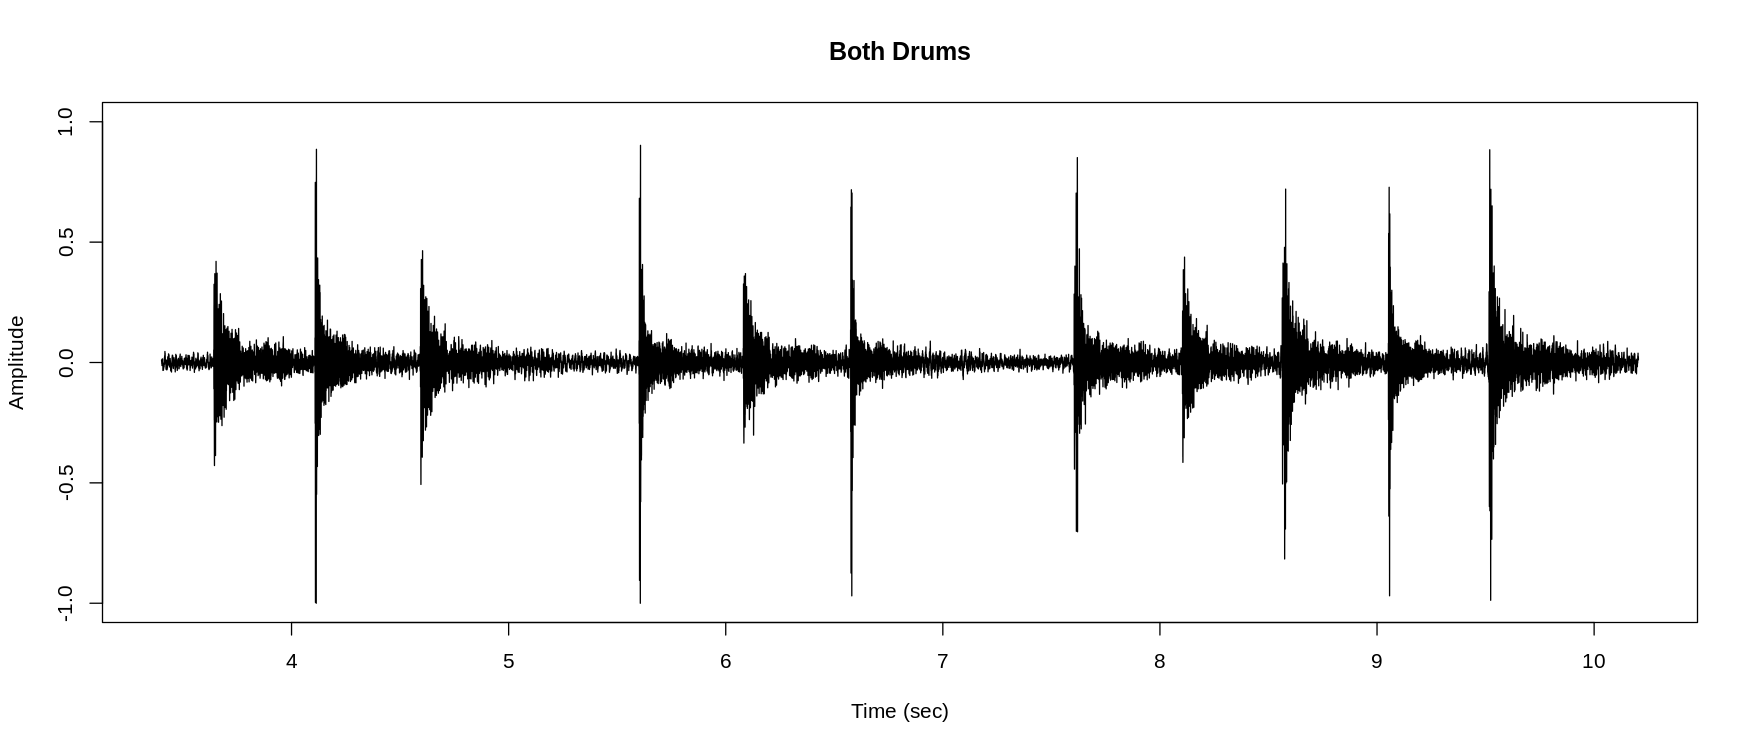

In [11]:
# For both drums

drums.time <- (0:(drums.num_samples - 1)) / drums.mp3@samp.rate
options(repr.plot.width=14, repr.plot.height=6, repr.plot.res = 125)
plot(drums.time[150000:450000], 
  drums.reduced[150000:450000],
  ylim=c(-1.0,1.0),
  type='l', 
  col='black',
  main = 'Both Drums',  
  xlab='Time (sec)', 
  ylab='Amplitude')

## Examining the data


We can use the `plotts.sample.wge` function from the `tswge` package to plot the sample autocorrelation and the periodograms. Since it takes a long time to compute these, we can look at a small snippet of the clips. 

Warning message in plotts.sample.wge(drum1.reduced, lag.max = 250):
“NaNs produced”


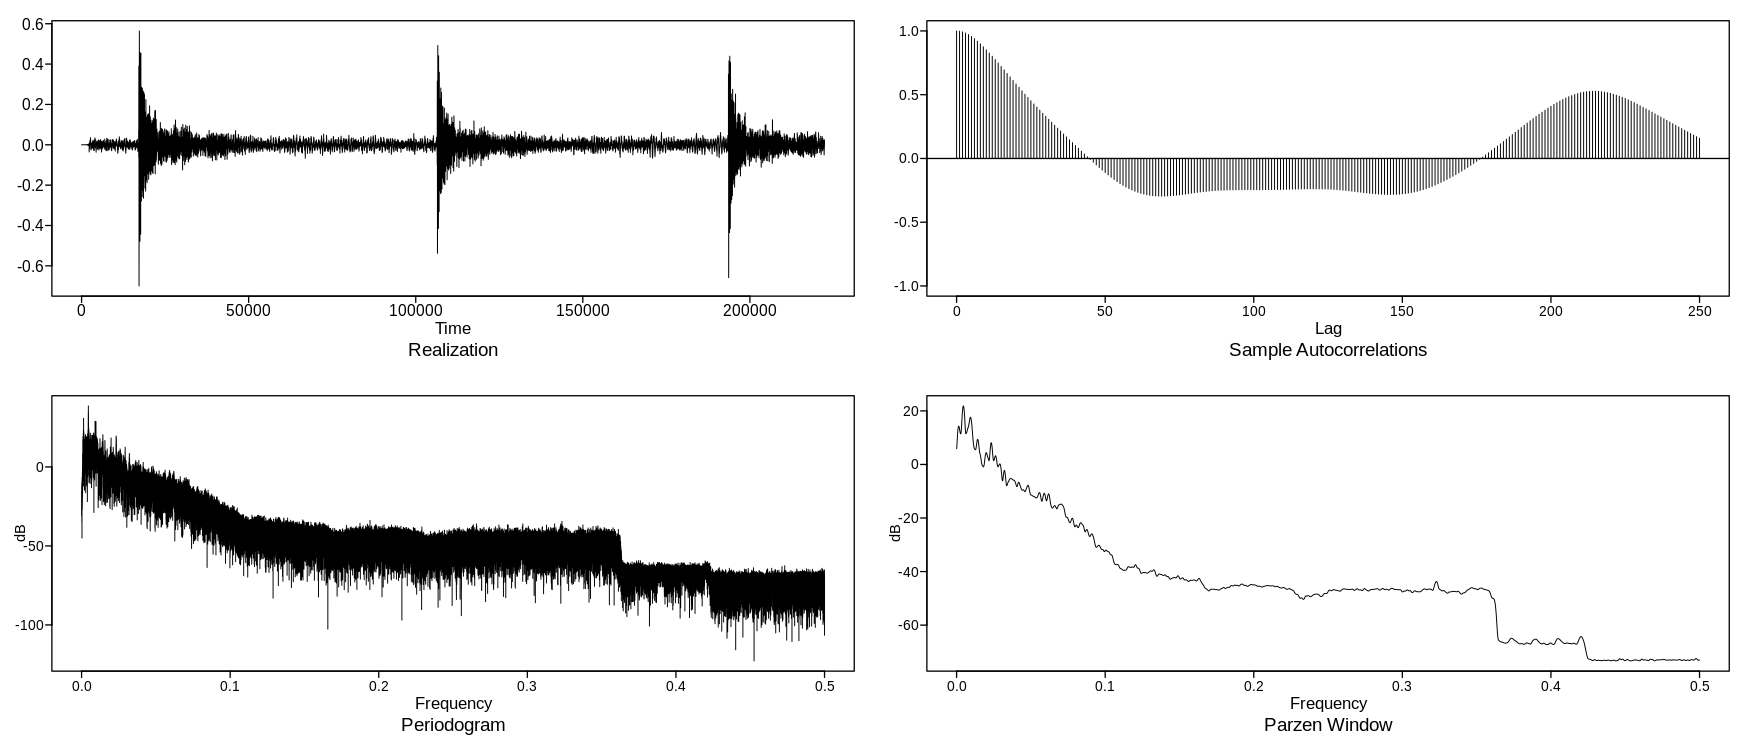

In [12]:
drum1.plotts <- plotts.sample.wge(drum1.reduced, lag.max = 250)

Warning message in plotts.sample.wge(drum2.reduced, lag.max = 250):
“NaNs produced”


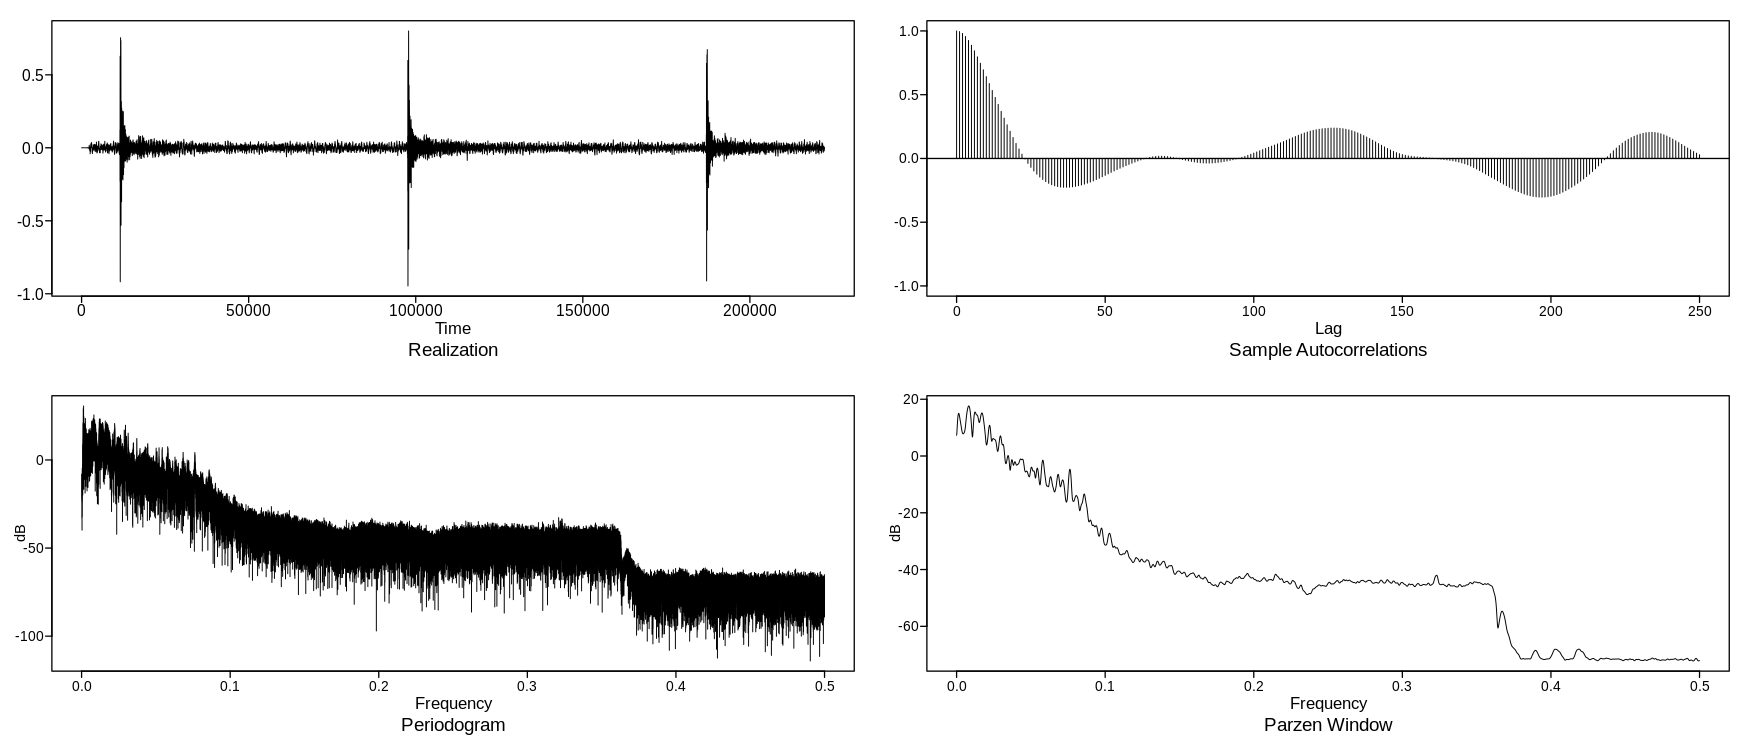

In [13]:
drum2.plotts <- plotts.sample.wge(drum2.reduced, lag.max = 250)

Warning message in plotts.sample.wge(drums.reduced[150000:450000], lag.max = 250):
“NaNs produced”


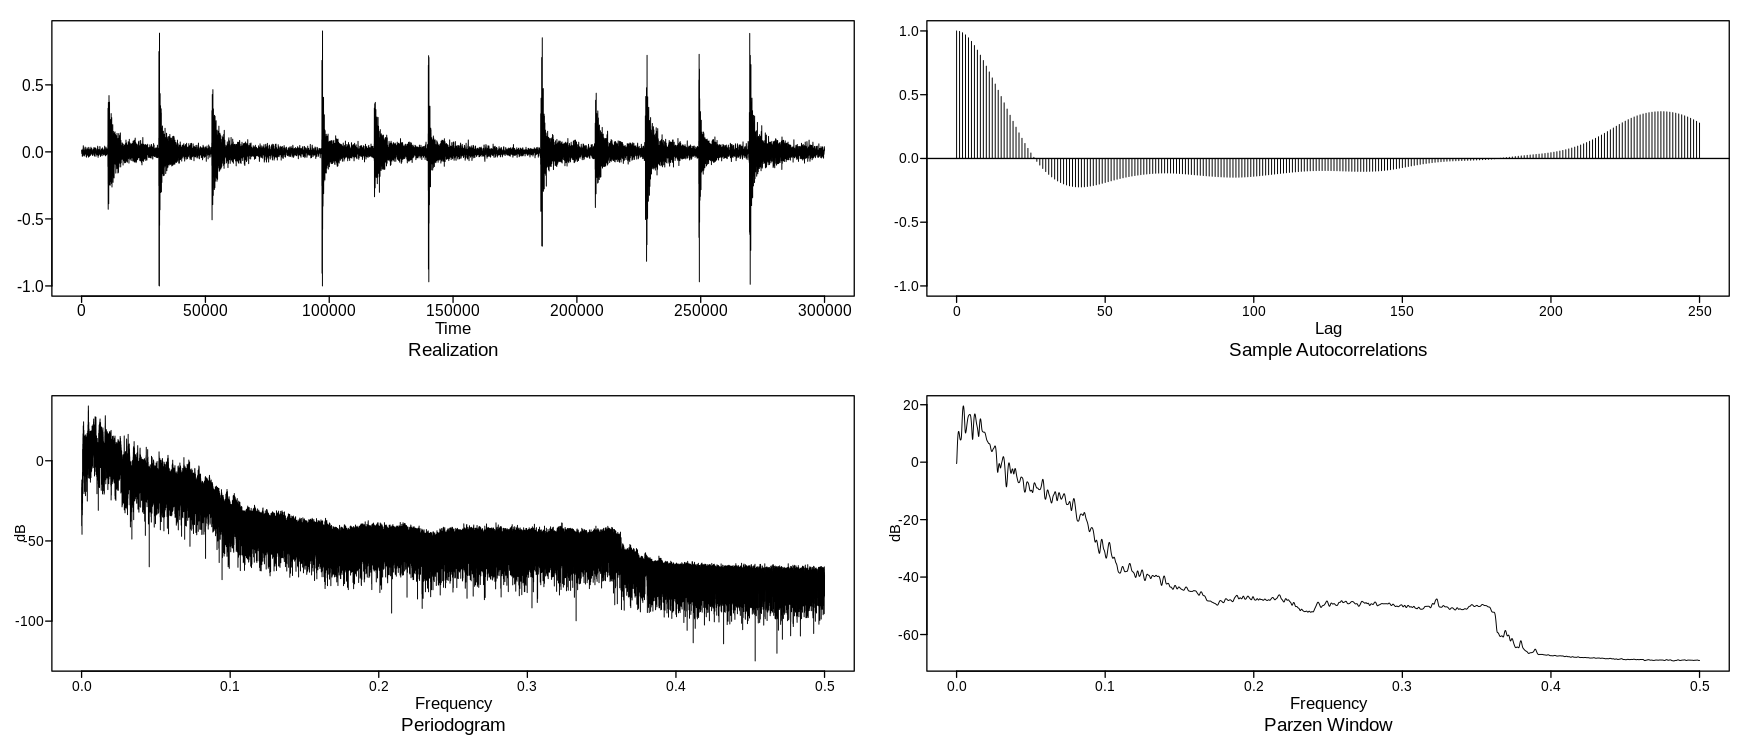

In [14]:
drums.plotts <- plotts.sample.wge(drums.reduced[150000:450000], lag.max = 250)

### Dominant Frequencies

First plot the periodogram:

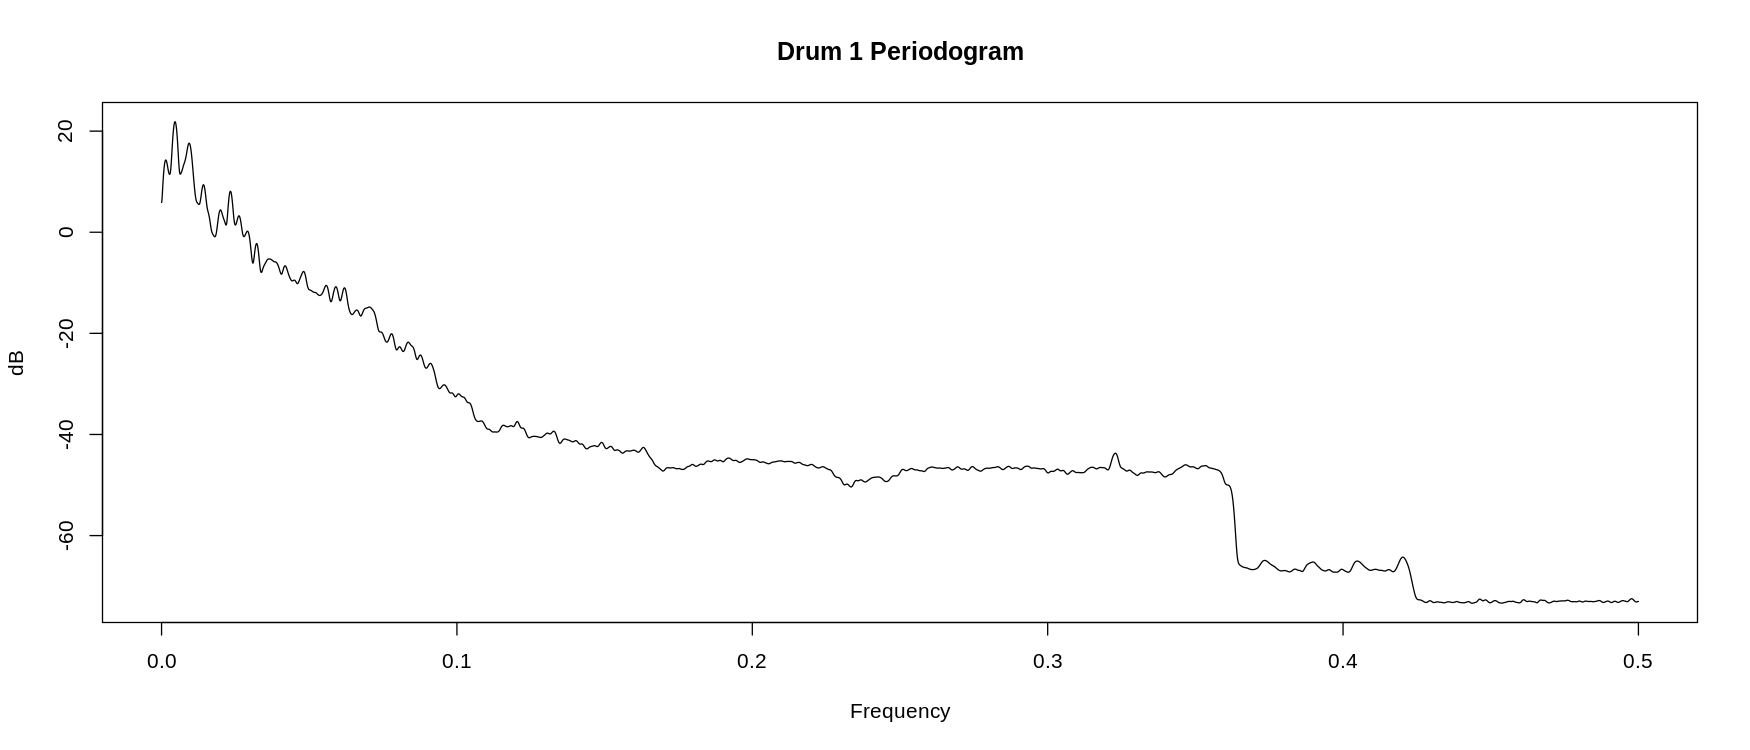

In [15]:
# Drum 1:
plot(drum1.plotts$freq, drum1.plotts$dbz, main = 'Drum 1 Periodogram', xlab = 'Frequency', ylab = 'dB', type = 'l')

To find a range of frequencies around the dominant frequency 18 can be adjusted lower to include more frequencies, however the lower the number, the less dominant the frequency is. This also applies to the 17.5 for drum 2 lower in the notebook

In [22]:
drum1.domfreq <- drum1.plotts$freq[which.max(drum1.plotts$dbz)]

drum1.plotts$freq[drum1.plotts$dbz > 18]

[1] 0.004560665

[1] 0.003728591 0.003733089 0.003737586 0.003742084 0.003746582 0.003751079
  [7] 0.003755577 0.003760075 0.003764573 0.003769070 0.003773568 0.003778066
 [13] 0.003782563 0.003787061 0.003791559 0.003796056 0.003800554 0.003805052
 [19] 0.003809550 0.003814047 0.003818545 0.003823043 0.003827540 0.003832038
 [25] 0.003836536 0.003841033 0.003845531 0.003850029 0.003854526 0.003859024
 [31] 0.003863522 0.003868020 0.003872517 0.003877015 0.003881513 0.003886010
 [37] 0.003890508 0.003895006 0.003899503 0.003904001 0.003908499 0.003912997
 [43] 0.003917494 0.003921992 0.003926490 0.003930987 0.003935485 0.003939983
 [49] 0.003944480 0.003948978 0.003953476 0.003957974 0.003962471 0.003966969
 [55] 0.003971467 0.003975964 0.003980462 0.003984960 0.003989457 0.003993955
 [61] 0.003998453 0.004002950 0.004007448 0.004011946 0.004016444 0.004020941
 [67] 0.004025439 0.004029937 0.004034434 0.004038932 0.004043430 0.004047927
 [73] 0.004052425 0.004056923 0.004061421 0.004065918 0.004070416 0.004074914
 [79] 0.004079411 0.004083909 0.004088407 0.004092904 0.004097402 0.004101900
 [85] 0.004106398 0.004110895 0.004115393 0.004119891 0.004124388 0.004128886
 [91] 0.004133384 0.004137881 0.004142379 0.004146877 0.004151374 0.004155872
 [97] 0.004160370 0.004164868 0.004169365 0.004173863 0.004178361 0.004182858
[103] 0.004187356 0.004191854 0.004196351 0.004200849 0.004205347 0.004209845
[109] 0.004214342 0.004218840 0.004223338 0.004227835 0.004232333 0.004236831
[115] 0.004241328 0.004245826 0.004250324 0.004254822 0.004259319 0.004263817
[121] 0.004268315 0.004272812 0.004277310 0.004281808 0.004286305 0.004290803
[127] 0.004295301 0.004299799 0.004304296 0.004308794 0.004313292 0.004317789
[133] 0.004322287 0.004326785 0.004331282 0.004335780 0.004340278 0.004344775
[139] 0.004349273 0.004353771 0.004358269 0.004362766 0.004367264 0.004371762
[145] 0.004376259 0.004380757 0.004385255 0.004389752 0.004394250 0.004398748
[151] 0.004403246 0.004407743 0.004412241 0.004416739 0.004421236 0.004425734
[157] 0.004430232 0.004434729 0.004439227 0.004443725 0.004448223 0.004452720
[163] 0.004457218 0.004461716 0.004466213 0.004470711 0.004475209 0.004479706
[169] 0.004484204 0.004488702 0.004493199 0.004497697 0.004502195 0.004506693
[175] 0.004511190 0.004515688 0.004520186 0.004524683 0.004529181 0.004533679
[181] 0.004538176 0.004542674 0.004547172 0.004551670 0.004556167 0.004560665
[187] 0.004565163 0.004569660 0.004574158 0.004578656 0.004583153 0.004587651
[193] 0.004592149 0.004596647 0.004601144 0.004605642 0.004610140 0.004614637
[199] 0.004619135 0.004623633 0.004628130 0.004632628 0.004637126 0.004641623
[205] 0.004646121 0.004650619 0.004655117 0.004659614 0.004664112 0.004668610
[211] 0.004673107 0.004677605 0.004682103 0.004686600 0.004691098 0.004695596
[217] 0.004700094 0.004704591 0.004709089 0.004713587 0.004718084 0.004722582
[223] 0.004727080 0.004731577 0.004736075 0.004740573 0.004745071 0.004749568
[229] 0.004754066 0.004758564 0.004763061 0.004767559 0.004772057 0.004776554
[235] 0.004781052 0.004785550 0.004790047 0.004794545 0.004799043 0.004803541
[241] 0.004808038 0.004812536 0.004817034 0.004821531 0.004826029 0.004830527
[247] 0.004835024 0.004839522 0.004844020 0.004848518 0.004853015 0.004857513
[253] 0.004862011 0.004866508 0.004871006 0.004875504 0.004880001 0.004884499
[259] 0.004888997 0.004893495 0.004897992 0.004902490 0.004906988 0.004911485
[265] 0.004915983 0.004920481 0.004924978 0.004929476 0.004933974 0.004938472
[271] 0.004942969 0.004947467 0.004951965 0.004956462 0.004960960 0.004965458
[277] 0.004969955 0.004974453 0.004978951 0.004983448 0.004987946 0.004992444
[283] 0.004996942 0.005001439 0.005005937 0.005010435 0.005014932 0.005019430
[289] 0.005023928 0.005028425 0.005032923 0.005037421 0.005041919 0.005046416
[295] 0.005050914 0.005055412 0.005059909 0.005064407 0.005068905 0.005073402
[301] 0.005077900 0.005082398 0.005086896 0.005091393 0.005095891 0.005100389
[307] 0.005104886 0.0051

Repeat with the other datasets:

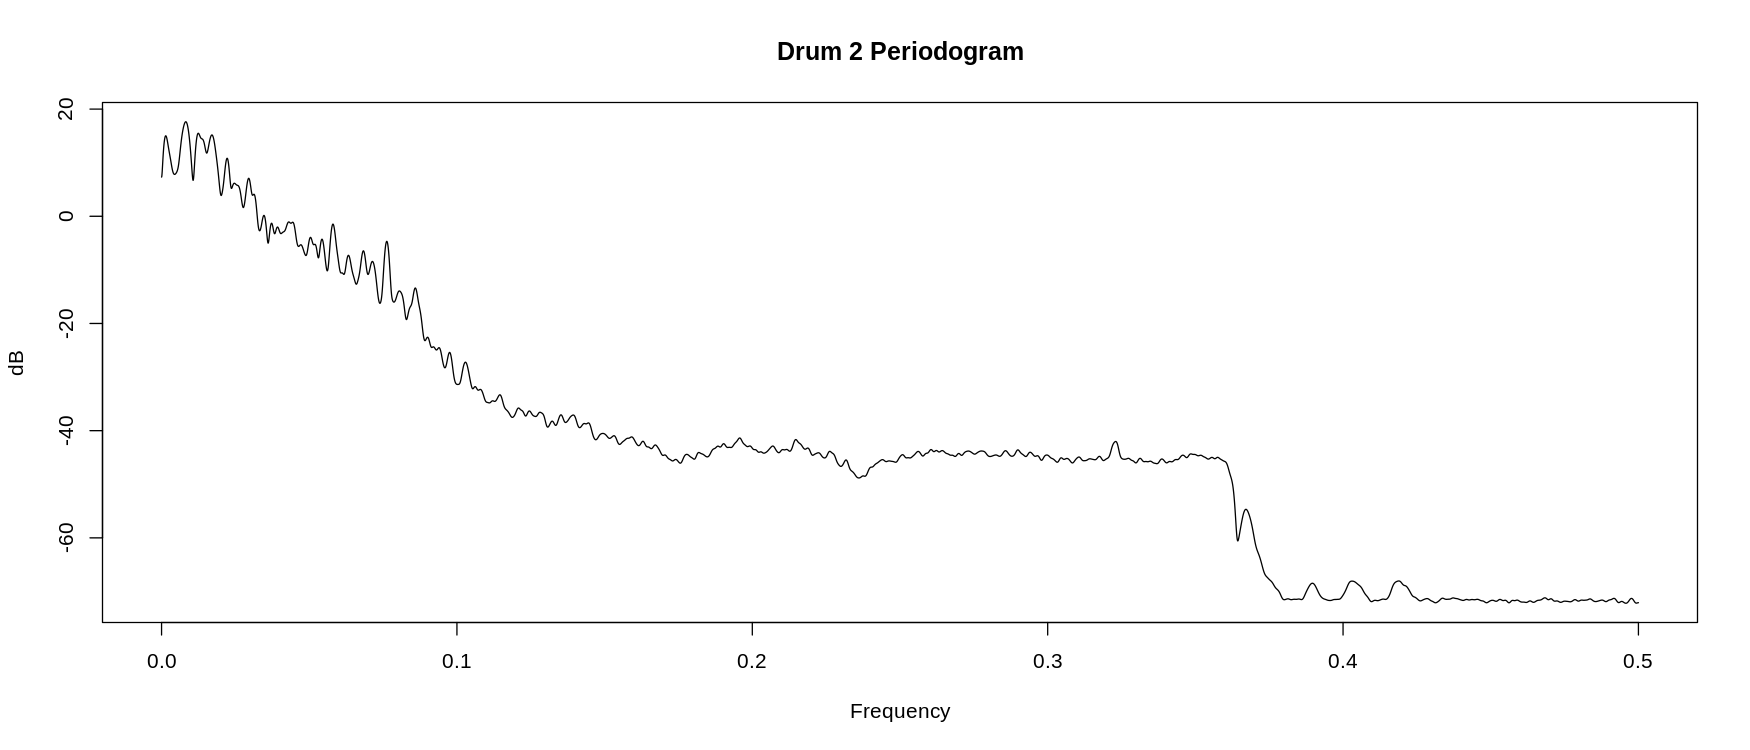

In [17]:
# Drum 2:
plot(drum2.plotts$freq, drum2.plotts$dbz, main = 'Drum 2 Periodogram', xlab = 'Frequency', ylab = 'dB', type = 'l')

With drum 2, the 18 decibels cutoff was too much and filtered out all of the values, so we used 17.5

In [23]:
drum2.domfreq <- drum2.plotts$freq[which.max(drum2.plotts$dbz)]

drum2.plotts$freq[drum2.plotts$dbz > 17.5]

[1] 0.007929440 0.007933938 0.007938436 0.007942933 0.007947431 0.007951929
  [7] 0.007956426 0.007960924 0.007965422 0.007969919 0.007974417 0.007978915
 [13] 0.007983412 0.007987910 0.007992408 0.007996906 0.008001403 0.008005901
 [19] 0.008010399 0.008014896 0.008019394 0.008023892 0.008028389 0.008032887
 [25] 0.008037385 0.008041883 0.008046380 0.008050878 0.008055376 0.008059873
 [31] 0.008064371 0.008068869 0.008073366 0.008077864 0.008082362 0.008086860
 [37] 0.008091357 0.008095855 0.008100353 0.008104850 0.008109348 0.008113846
 [43] 0.008118343 0.008122841 0.008127339 0.008131836 0.008136334 0.008140832
 [49] 0.008145330 0.008149827 0.008154325 0.008158823 0.008163320 0.008167818
 [55] 0.008172316 0.008176813 0.008181311 0.008185809 0.008190307 0.008194804
 [61] 0.008199302 0.008203800 0.008208297 0.008212795 0.008217293 0.008221790
 [67] 0.008226288 0.008230786 0.008235284 0.008239781 0.008244279 0.008248777
 [73] 0.008253274 0.008257772 0.008262270 0.008266767 0.008271265 0.008275763
 [79] 0.008280261 0.008284758 0.008289256 0.008293754 0.008298251 0.008302749
 [85] 0.008307247 0.008311744 0.008316242 0.008320740 0.008325237 0.008329735
 [91] 0.008334233 0.008338731 0.008343228 0.008347726 0.008352224 0.008356721
 [97] 0.008361219 0.008365717 0.008370214 0.008374712 0.008379210 0.008383708
[103] 0.008388205 0.008392703 0.008397201 0.008401698 0.008406196 0.008410694
[109] 0.008415191 0.008419689 0.008424187 0.008428685 0.008433182 0.008437680
[115] 0.008442178 0.008446675 0.008451173 0.008455671 0.008460168

For the audio clip with both drums, we should expect to see multiple dominant frequencies since there are two different pitches being played. 

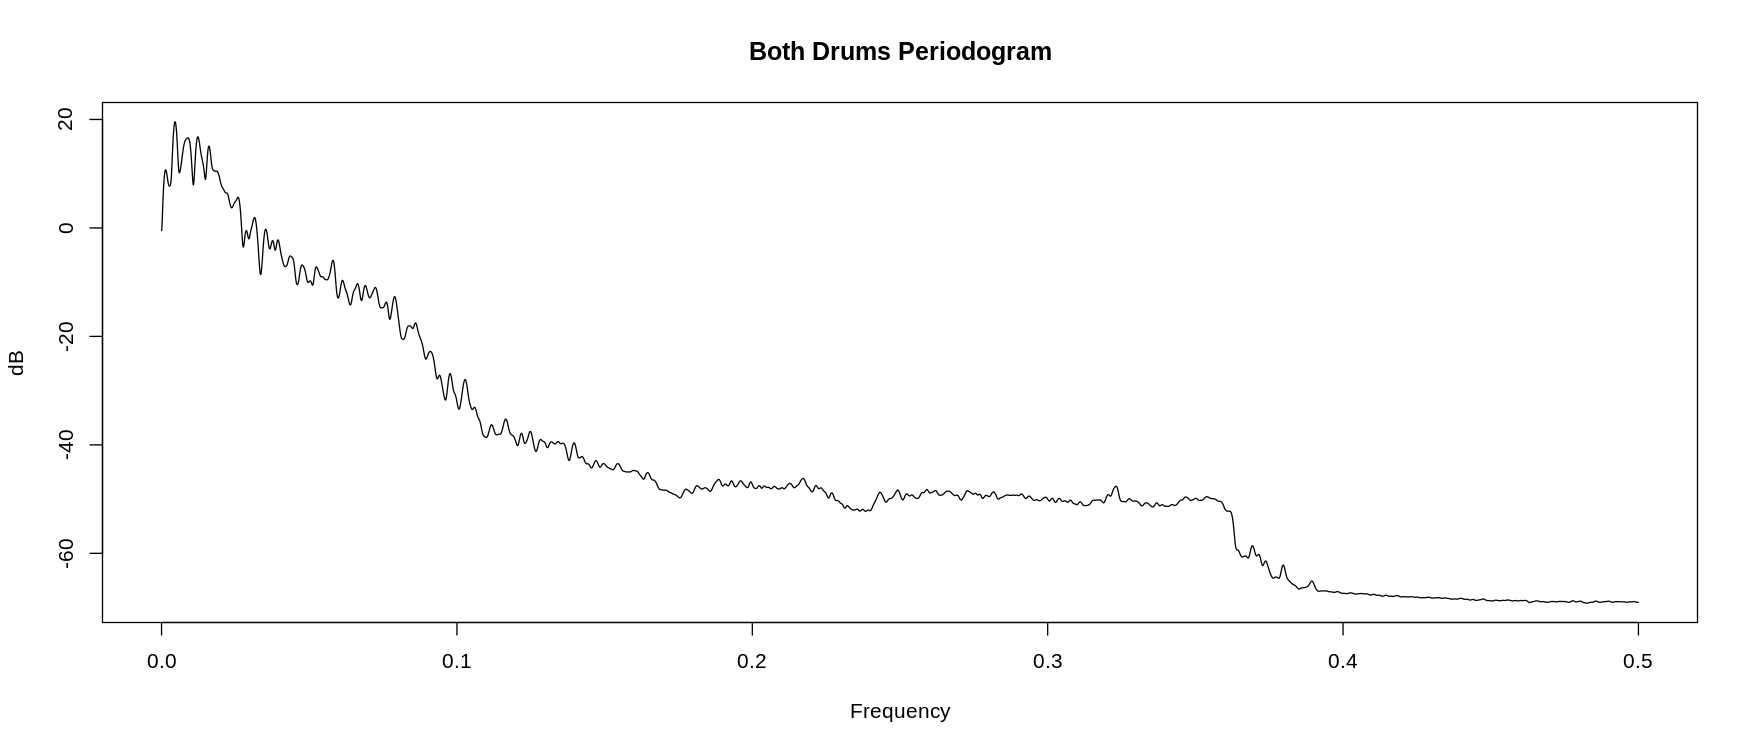

In [19]:
# Both Drums: 
plot(drums.plotts$freq, drums.plotts$dbz, main = 'Both Drums Periodogram', xlab = 'Frequency', ylab = 'dB', type = 'l')

For the audio track with both drums playing, we expected to find distinct frequencies of each individual drum when each played individually and a more "mixed," averaged frequency when the drums played together with a higher amplitude. This is because frequency is what defines the pitch of a sound and amplitude is what defines the volume (or, how "loud") of a sound.

## Filtering the data

To filter the data, we tried using a couple different methods. First, we tried using a high-pass Butterworth filter using the `butterworth.wge` function in the `tswge` package. We used the dominant frequency of drum 1 as the cutoff value, since it is the lower frequency.

Warning message in plotts.sample.wge(highp4$x.filt, lag.max = 250):
“NaNs produced”


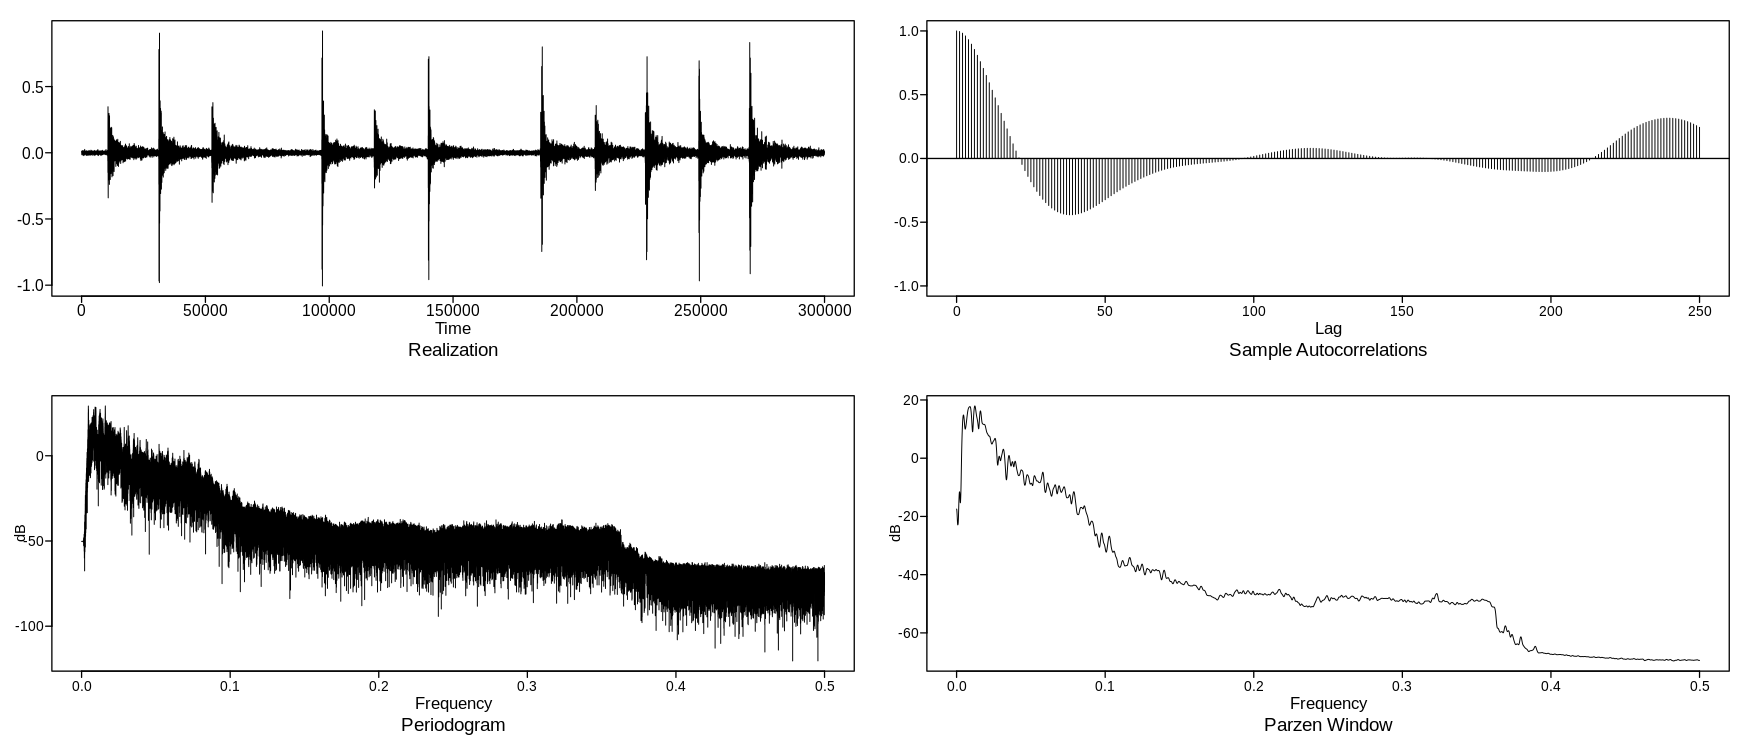

In [24]:
highp4 <- butterworth.wge(drums.reduced[150000:450000], 4, type = 'high', cutoff = drum1.domfreq, plot = FALSE)
drums.filtered <- plotts.sample.wge(highp4$x.filt, lag.max = 250)

We also tried using a higher order of 8 since it is more of a drastic change from high to low (a steeper line). 

Warning message in plotts.sample.wge(highp8$x.filt, lag.max = 250):
“NaNs produced”


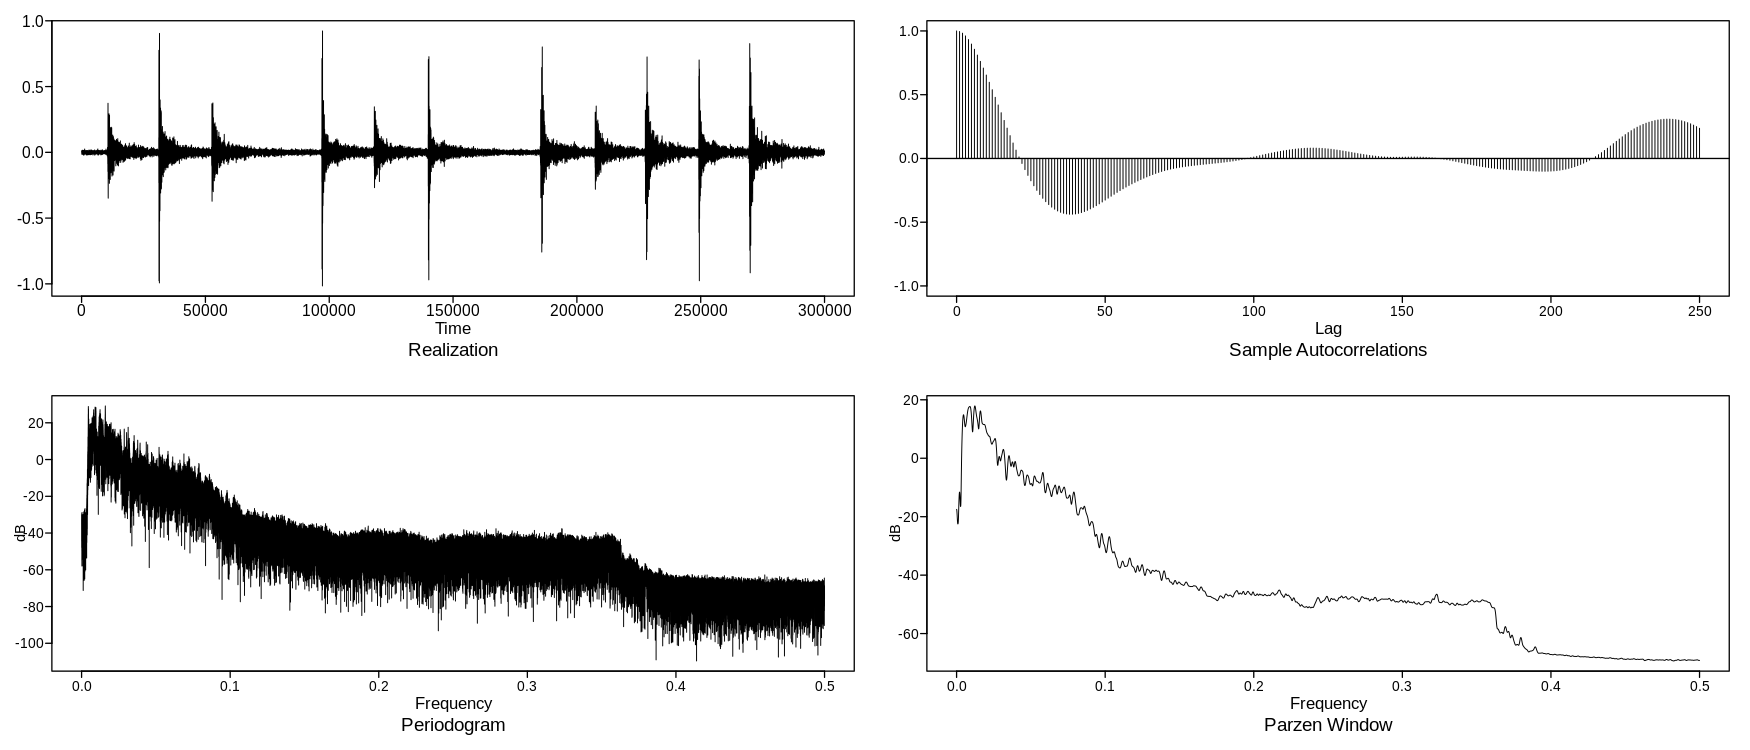

In [25]:
highp8 <- butterworth.wge(drums.reduced[150000:450000], 8, type = 'high', cutoff = drum1.domfreq, plot = FALSE)
drums.filtered <- plotts.sample.wge(highp8$x.filt, lag.max = 250)

Upon listening to the filtered results with the following code: 

In [26]:
drums.wave = Wave(highp4$x.filt, samp.rate = 44100, bit = 16)
drums.final <- normalize(drums.wave, unit = '16')
#play(drums.final) # unsupported in colab

# save as wav file
writeWave(drums.final, "/tmp/my.wav", extensible = TRUE)

We found that the audio file was more or less unchanged and did not produce the desired results. We decided to experiment with different filters to fix this problem. 


Here, we attempted to use a combination of stop and pass filters to target specific frequency ranges in hopes that it would improve the results. However, in the end we found that the best method was to find a middleground frequency as the cutoff between the high and low drums. 

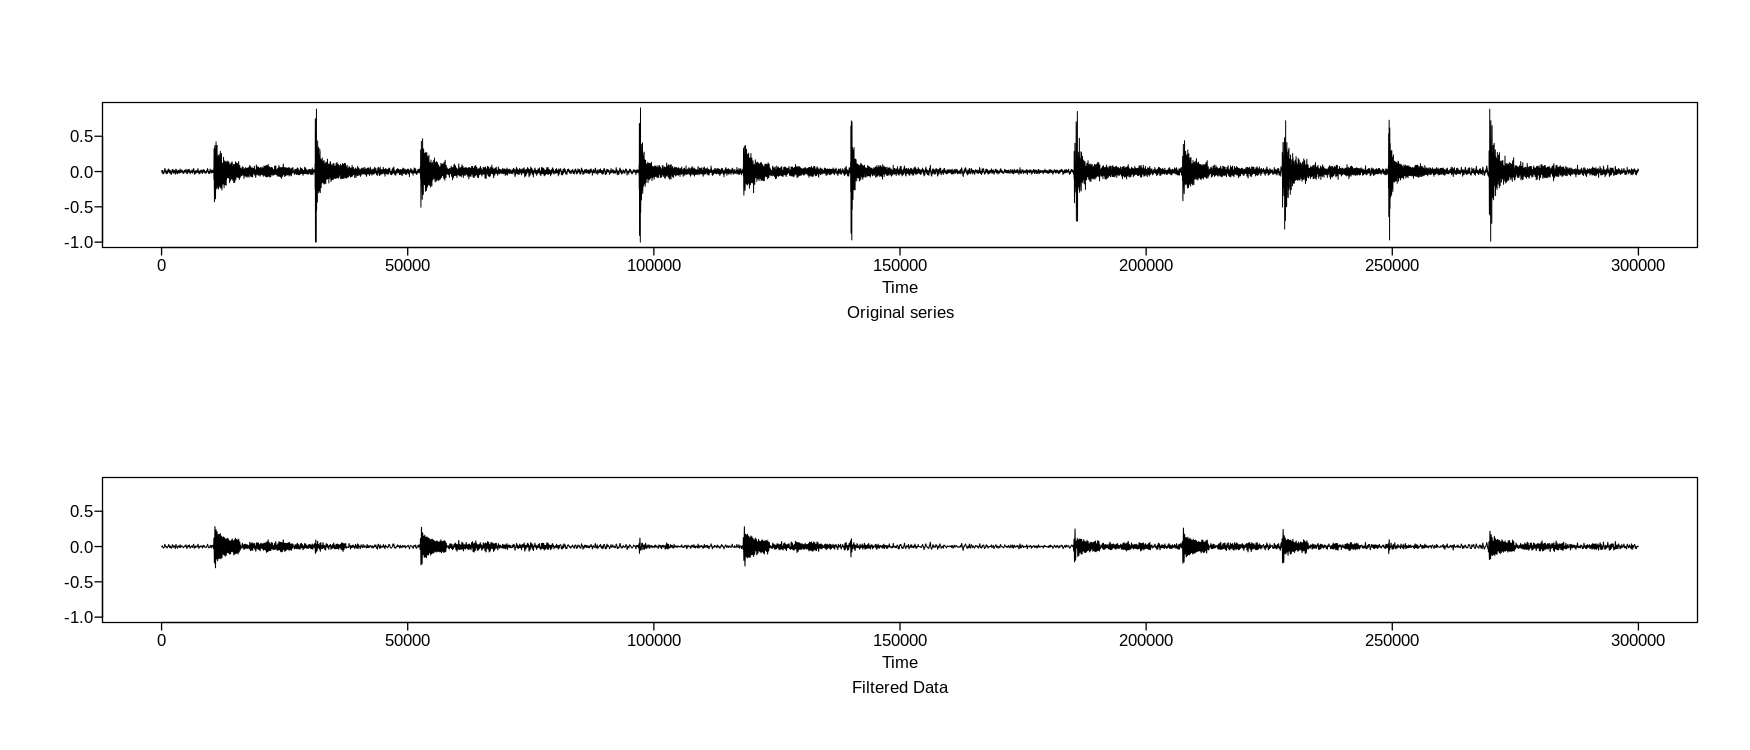

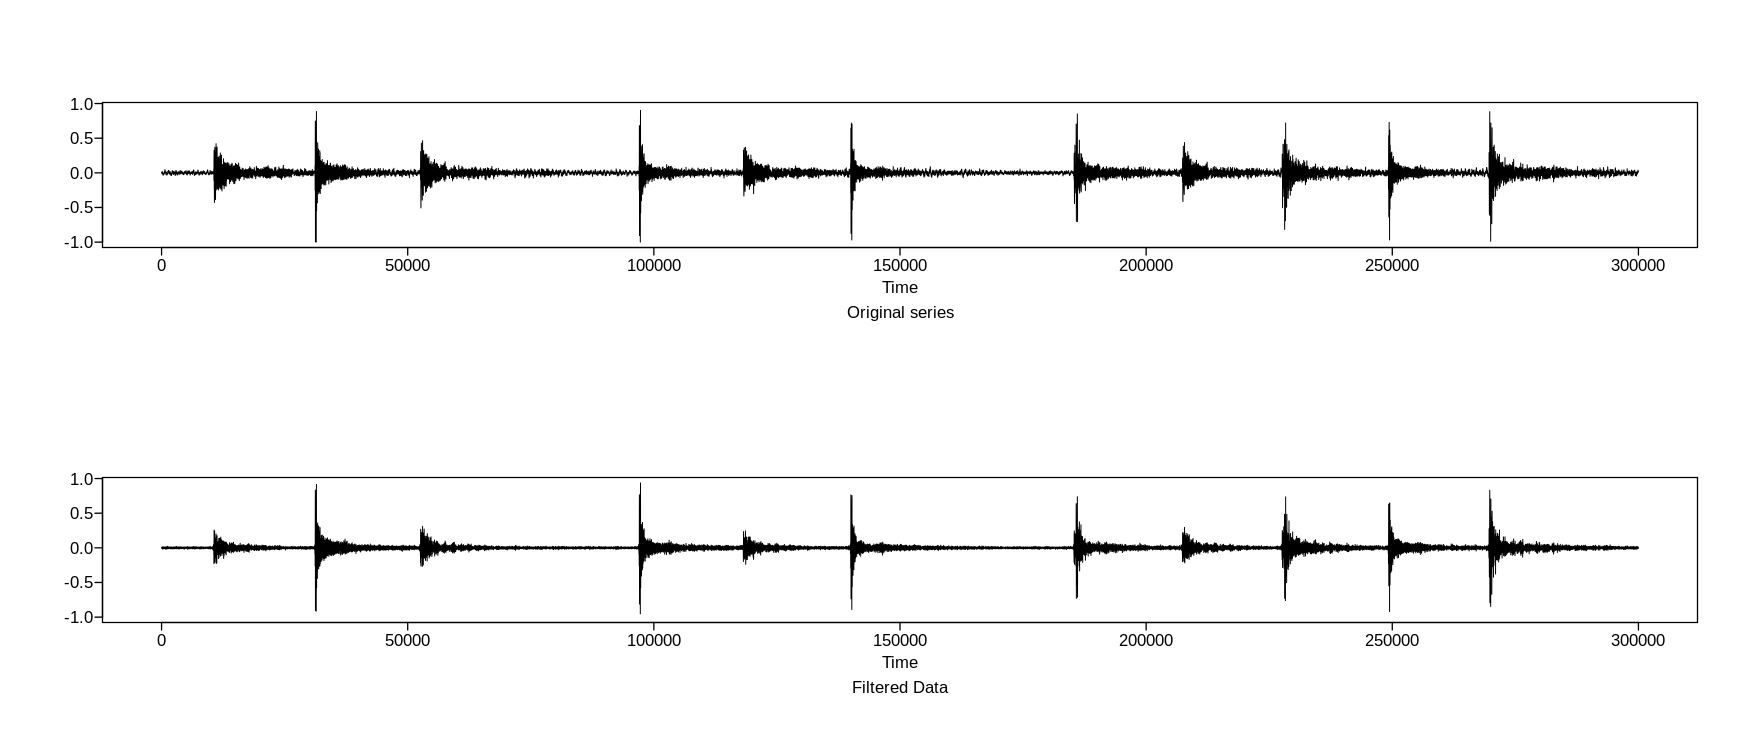

In [27]:
# these are the filters that worked best for me after some trial and error. pass and stop filters, but
# they seemed to always cut off too much or too little. it doesn't help that the 'low' drum has some 
# dominant frequencies that are higher than the 'high' drum and vice versa so it isn't perfect

lowp9 <- butterworth.wge(drums.reduced[150000:450000], 9, type = 'low', cutoff = .0065)
highp9 <- butterworth.wge(drums.reduced[150000:450000], 9, type = 'high', cutoff = .0065)

In [28]:
# save it as a wav file and play it back 

#for lowp9
drums.lowp9.wave = Wave(lowp9$x.filt, samp.rate = 44100, bit = 16)
drums.lowp9.final <- normalize(drums.lowp9.wave, unit = '16')
#play(drums.lowp9.final)

# save as wav file
writeWave(drums.lowp9.final, "/tmp/lowp9.wav", extensible = TRUE)

# for highp9
drums.highp9.wave = Wave(highp9$x.filt, samp.rate = 44100, bit = 16)
drums.highp9.final <- normalize(drums.highp9.wave, unit = '16')
#play(drums.highp9.final)

# save as wav file
writeWave(drums.highp9.final, "/tmp/highp9.wav", extensible = TRUE)

The files produced by lowp9 and highp9 can be found on github with the names d1filt.wav and d2filt.wav.

## ... Continued ?

Perhaps there are other methods of filtering?

In [29]:
# David's

# using seewave
# make a copy of drums
test0 <- drums.reduced[150000:450000]

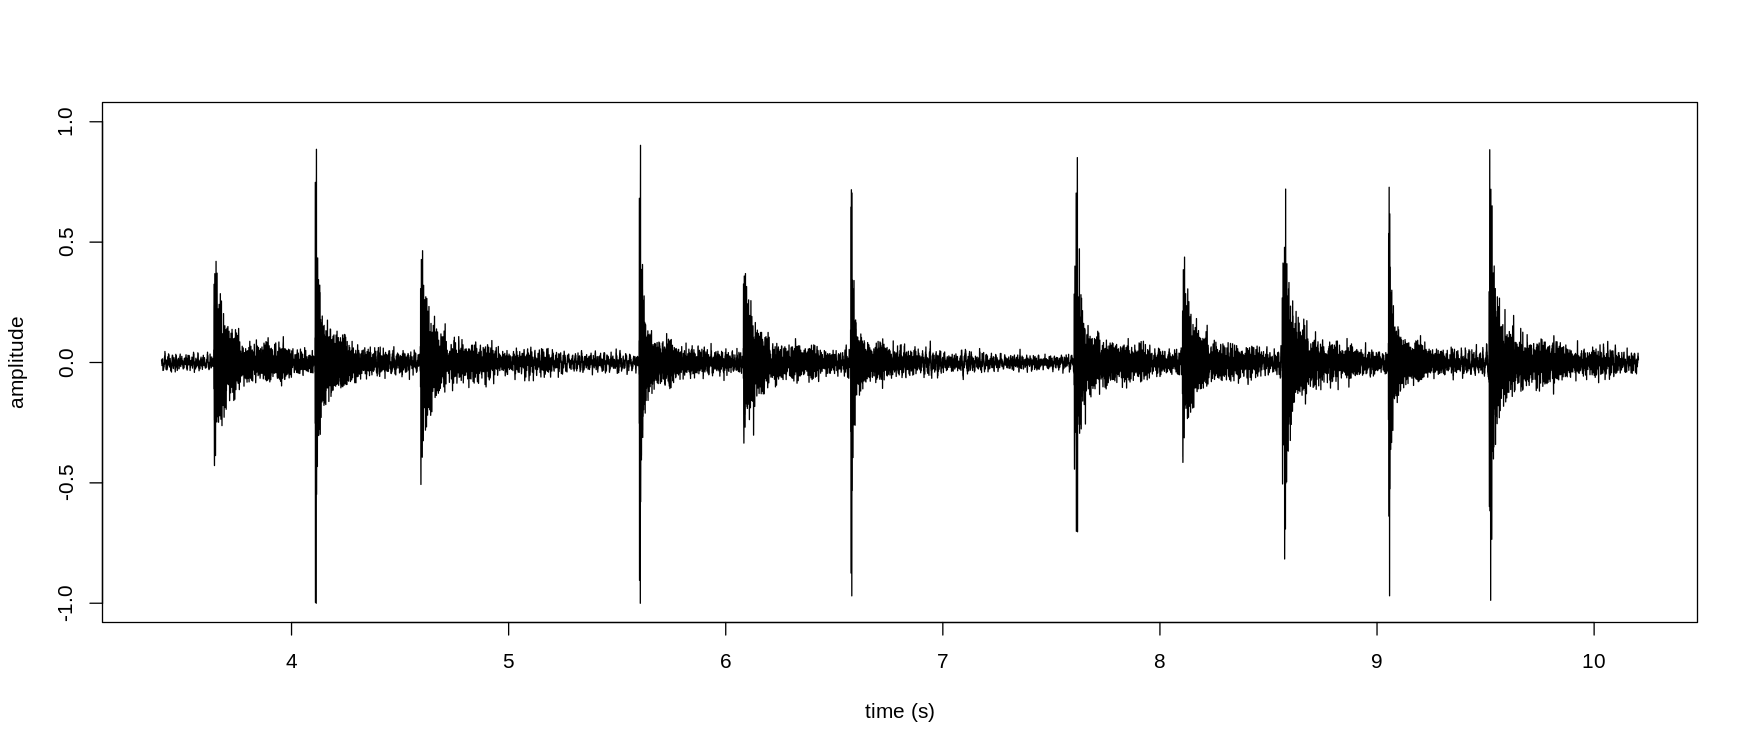

In [30]:
plot(drums.time[150000:450000],
  test0,
  type='l',
  ylim = c(-1.0,1.0),
  xlab = "time (s)",
  ylab = "amplitude"
)

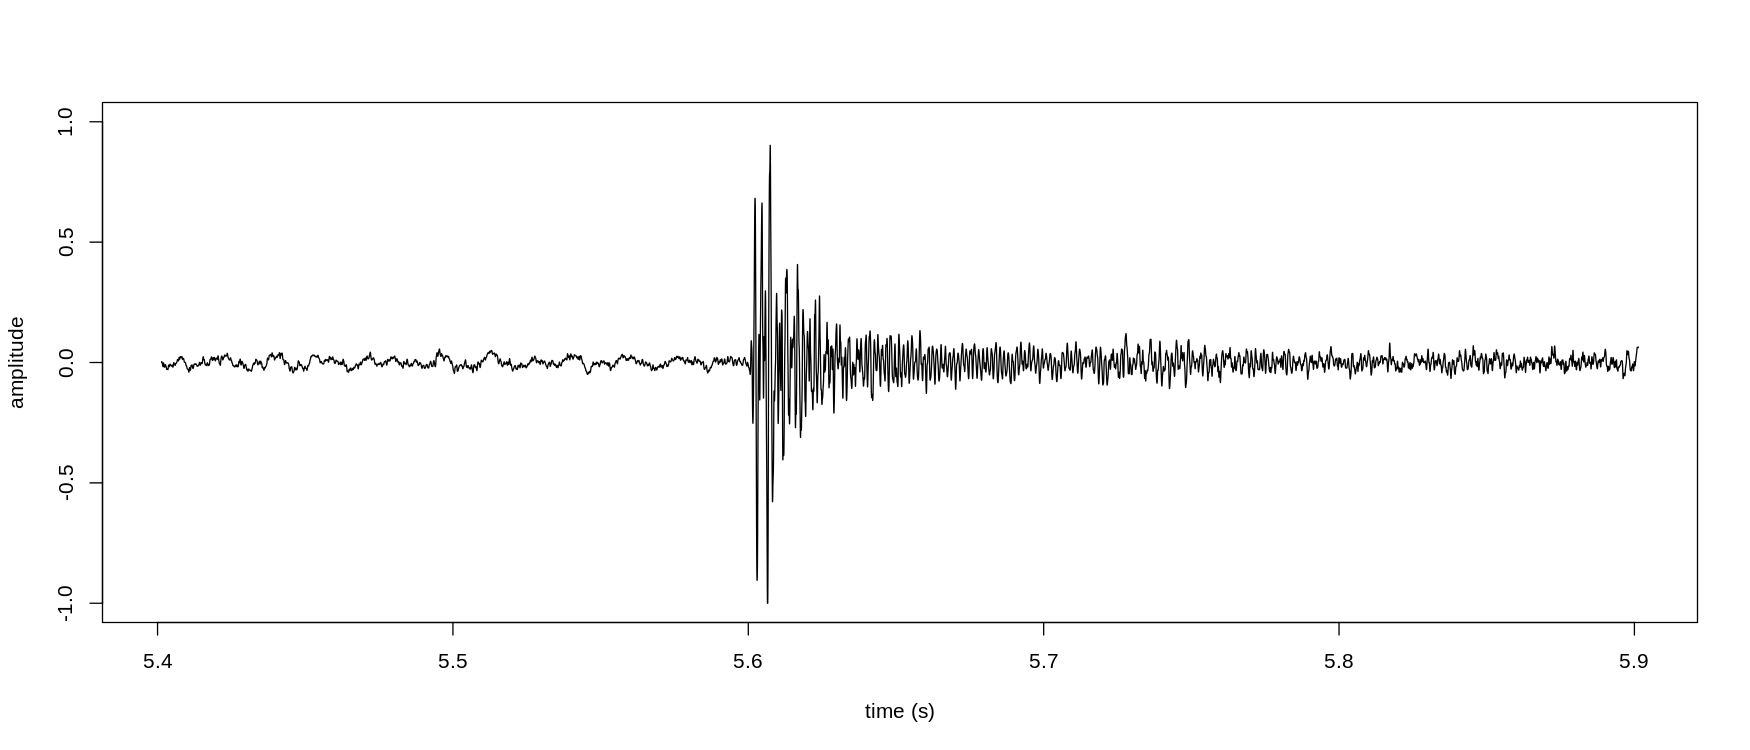

In [31]:
# take a look at a smaller section
i = 5
plot(drums.time[((i-1)*22050+1+150000):(i*22050+1+150000)],
  test0[((i-1)*22050+1):(i*22050+1)],
  type = 'l',
  ylim = c(-1.0,1.0),
  xlab = "time (s)",
  ylab = "amplitude"
)

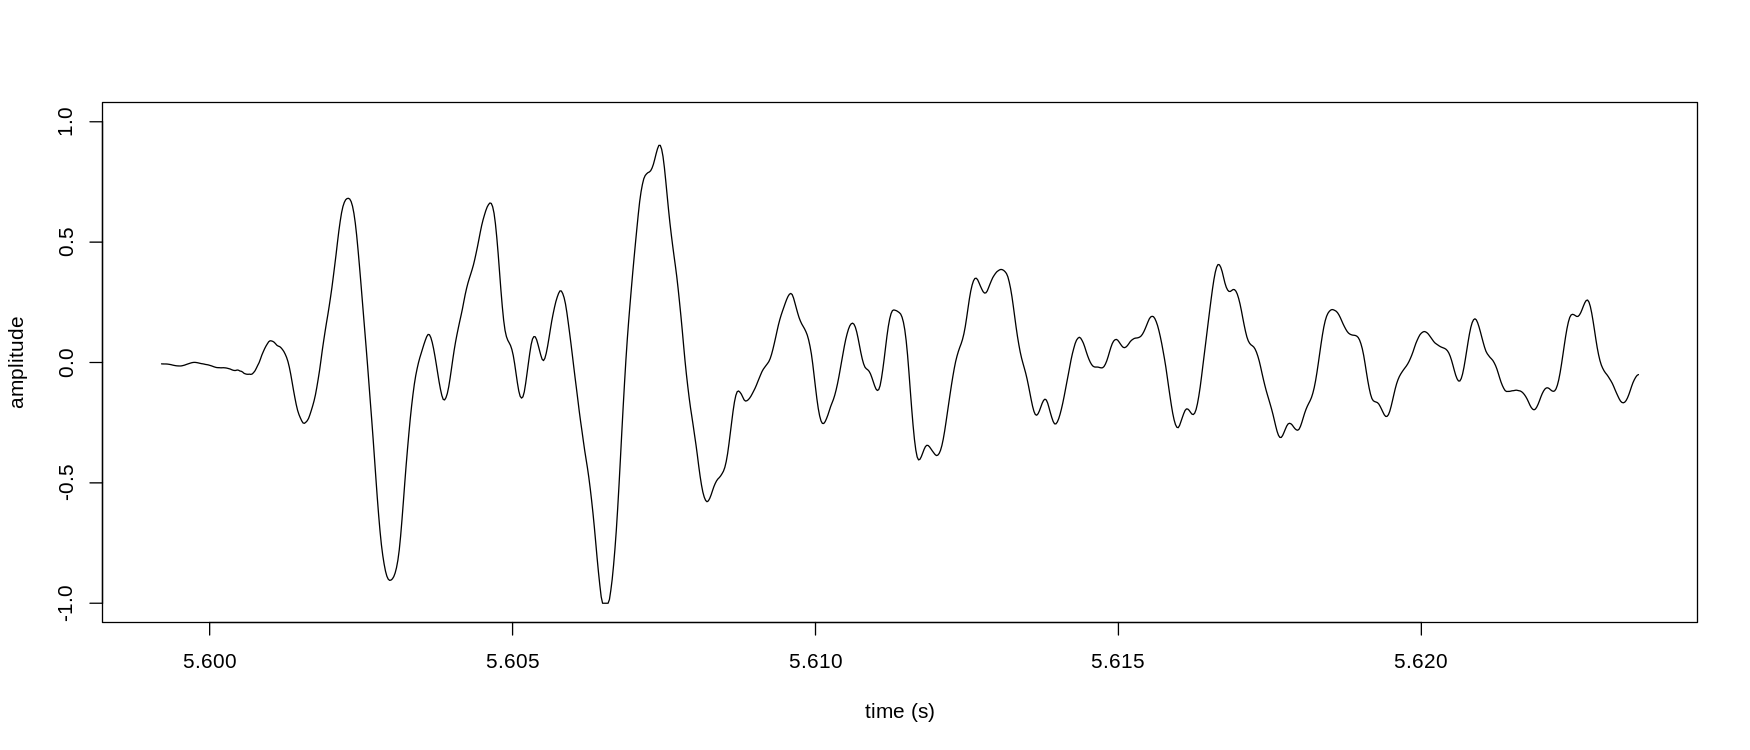

In [32]:
i = 5
plot(drums.time[((i-1)*22050+1+150000+8725):(i*22050+1+150000-12250)],
  test0[((i-1)*22050+1+8725):(i*22050+1-12250)],
  type = 'l',
  ylim = c(-1.0,1.0),
  xlab = "time (s)",
  ylab = "amplitude"
)

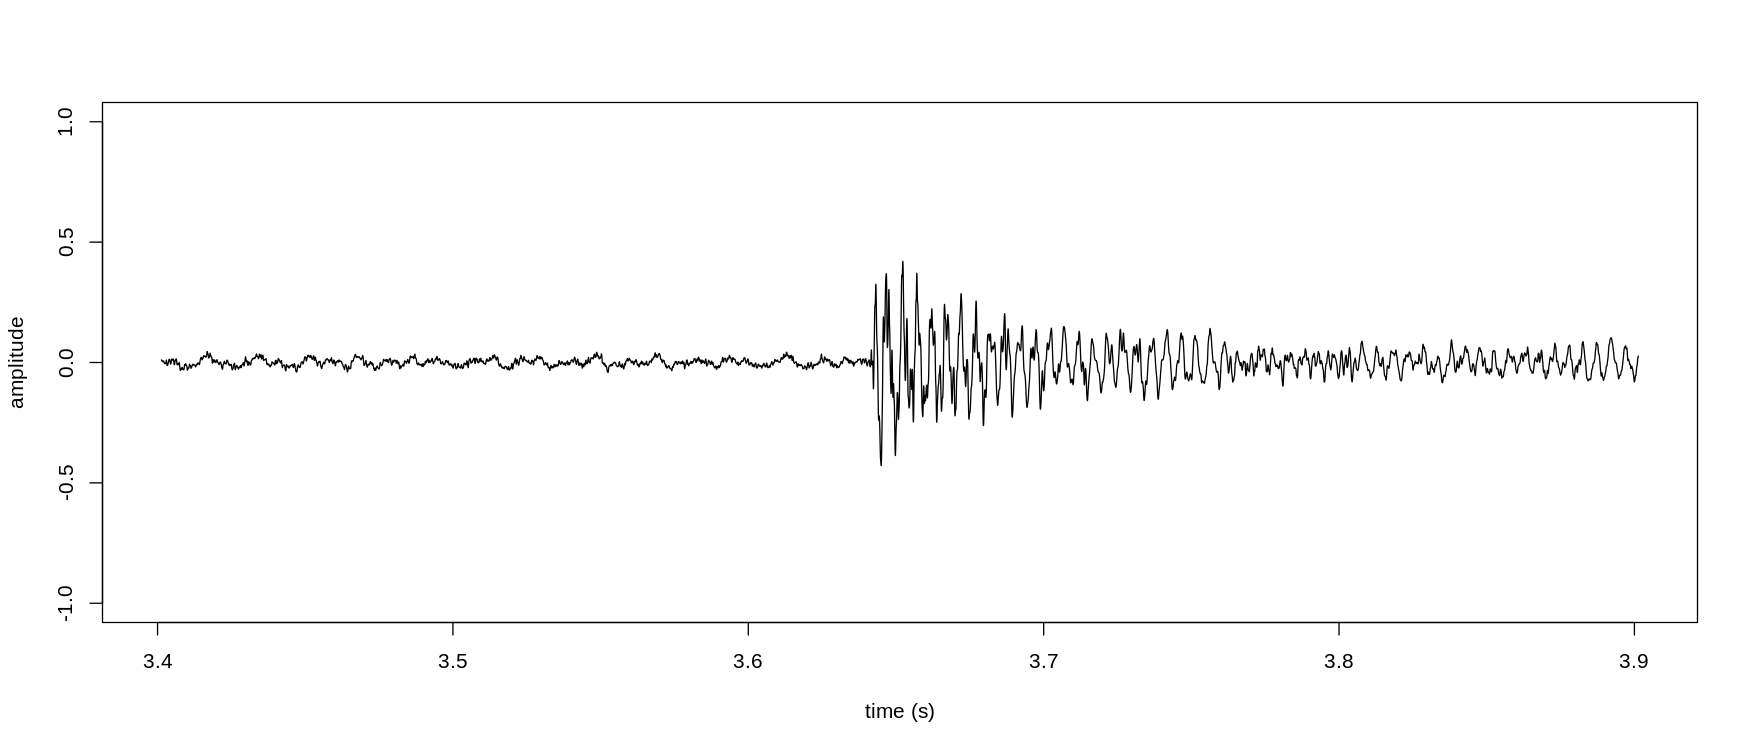

In [33]:
i = 1
plot(drums.time[((i-1)*22050+1+150000):(i*22050+1+150000)],
  test0[((i-1)*22050+1):(i*22050+1)],
  type = 'l',
  ylim = c(-1.0,1.0),
  xlab = "time (s)",
  ylab = "amplitude"
)

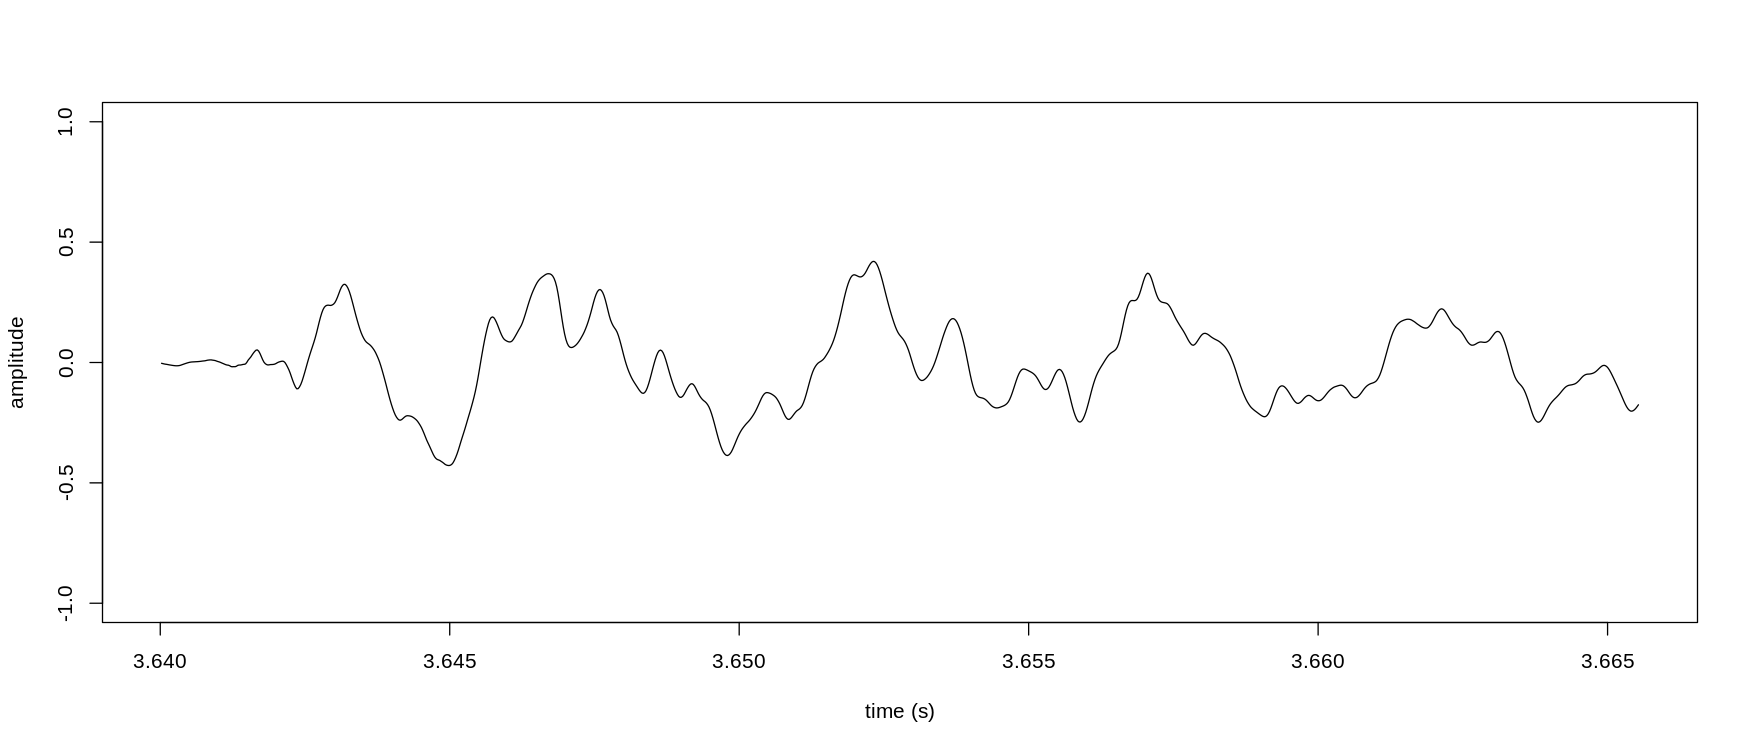

In [34]:
i = 1
plot(drums.time[((i-1)*22050+1+150000+10525):(i*22050+1+150000-10400)],
  test0[((i-1)*22050+1+10525):(i*22050+1-10400)],
  type = 'l',
  ylim = c(-1.0,1.0),
  xlab = "time (s)",
  ylab = "amplitude"
)

We can now download the .wav and play it back to an online tuner to get the Hz reading.

We found that...  
drum2 (high): plays at around 850 Hz  
drum1 (low): around 300-400 Hz 

We can then put this through a frequency filter provided by the seewave package, and then plot the results. This would have a high-pass and low-pass, but for the frequencies instead.

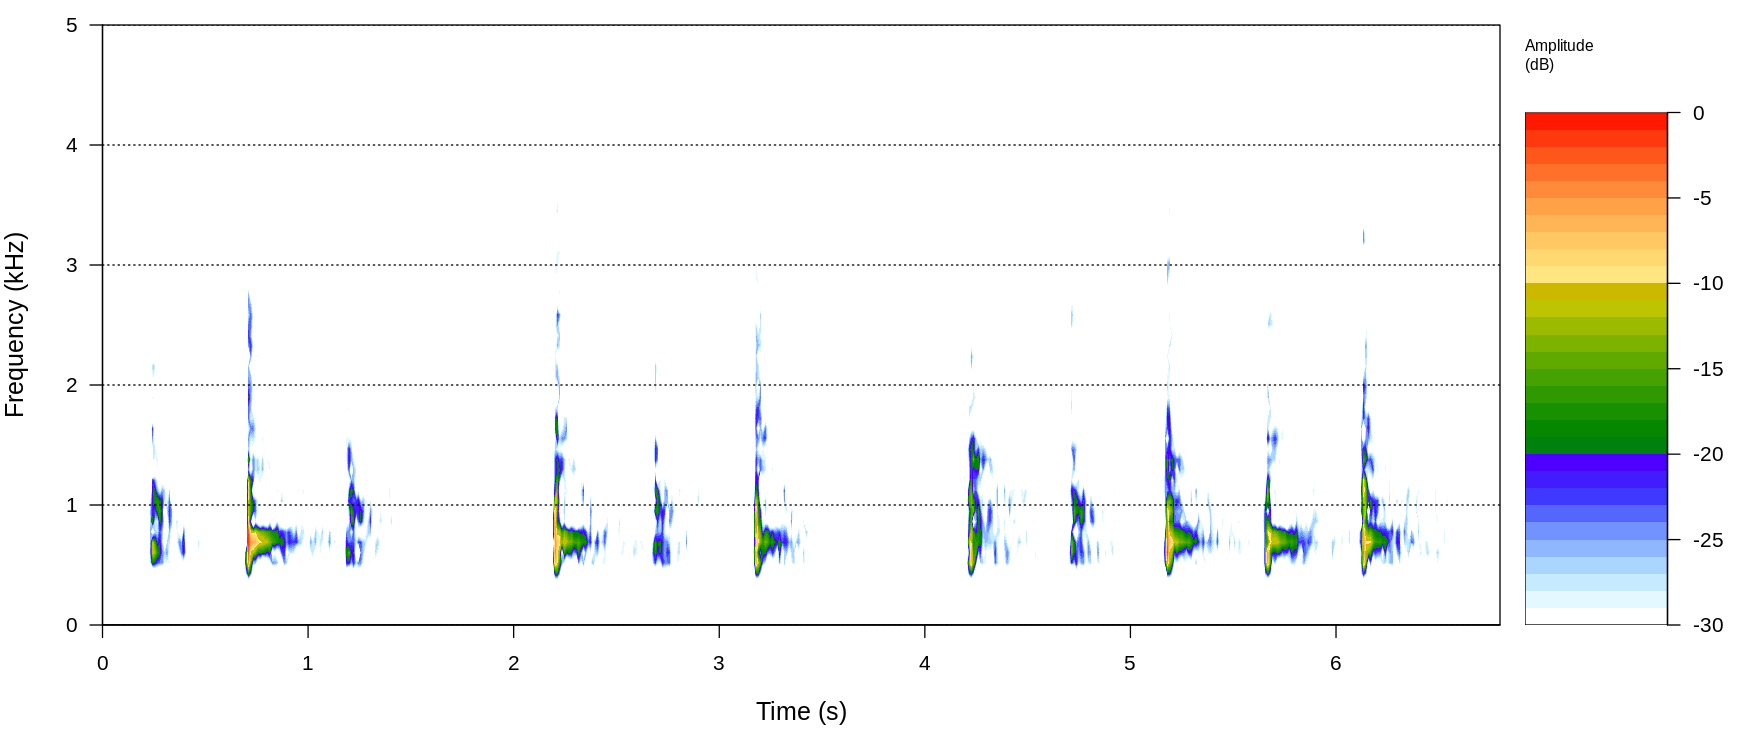

In [35]:
# high-pass filter; should get second drum only (high-pitched)
c1 <- ffilter(test0, f=44100, from = 600)
spectro(c1, f=44100, wl=512, flim = c(0,5))

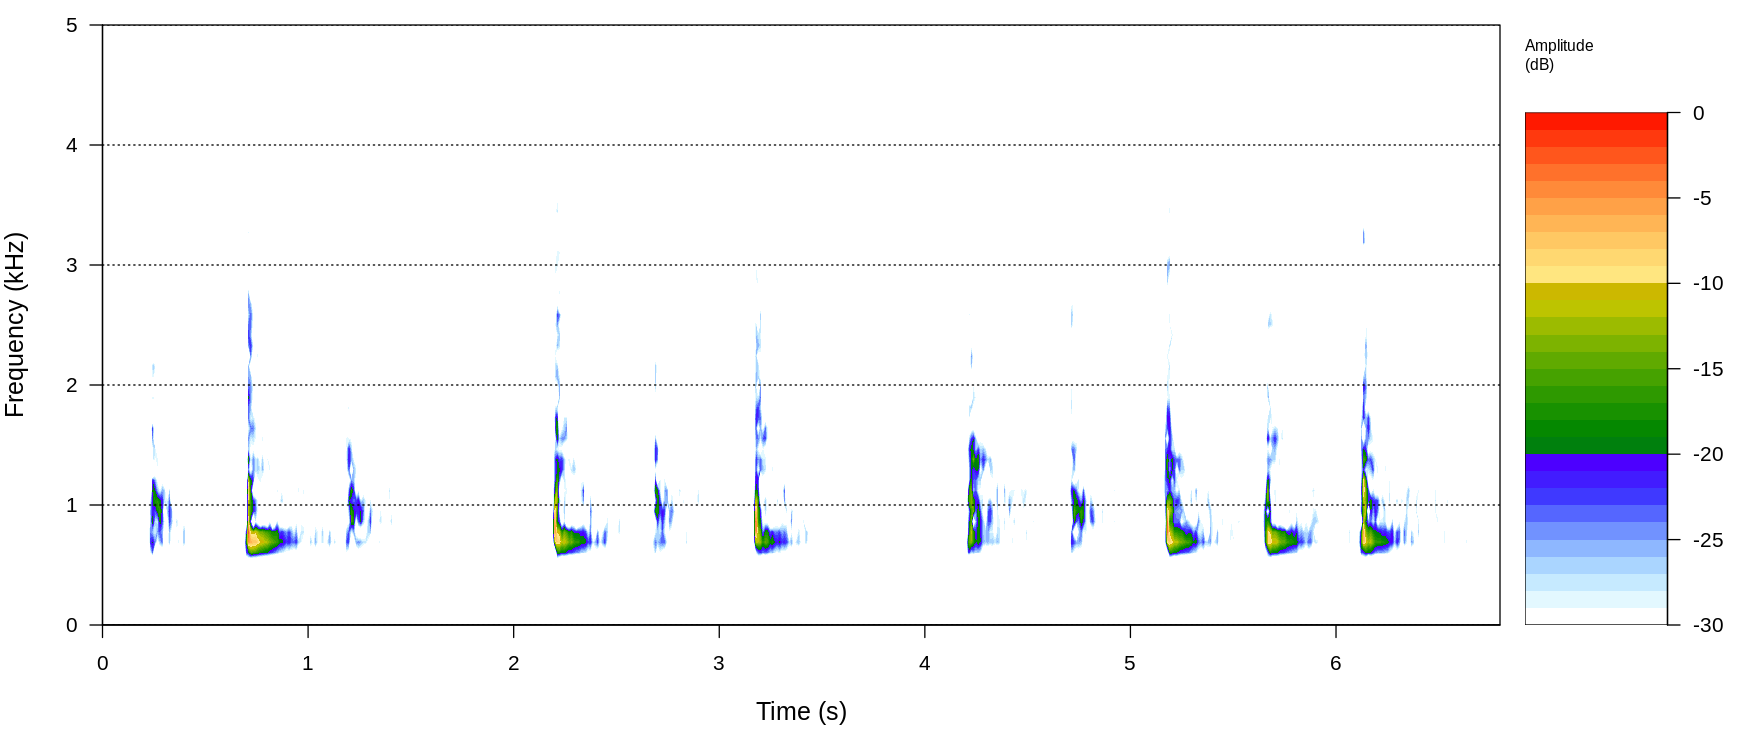

In [36]:
# can also use a higher, tighter frequency bound of 700

# high-pass filter; should get second drum only (high-pitched)
c2 <- ffilter(test0, f=44100, from = 700)
spectro(c2, f=44100, wl=512, flim = c(0,5))

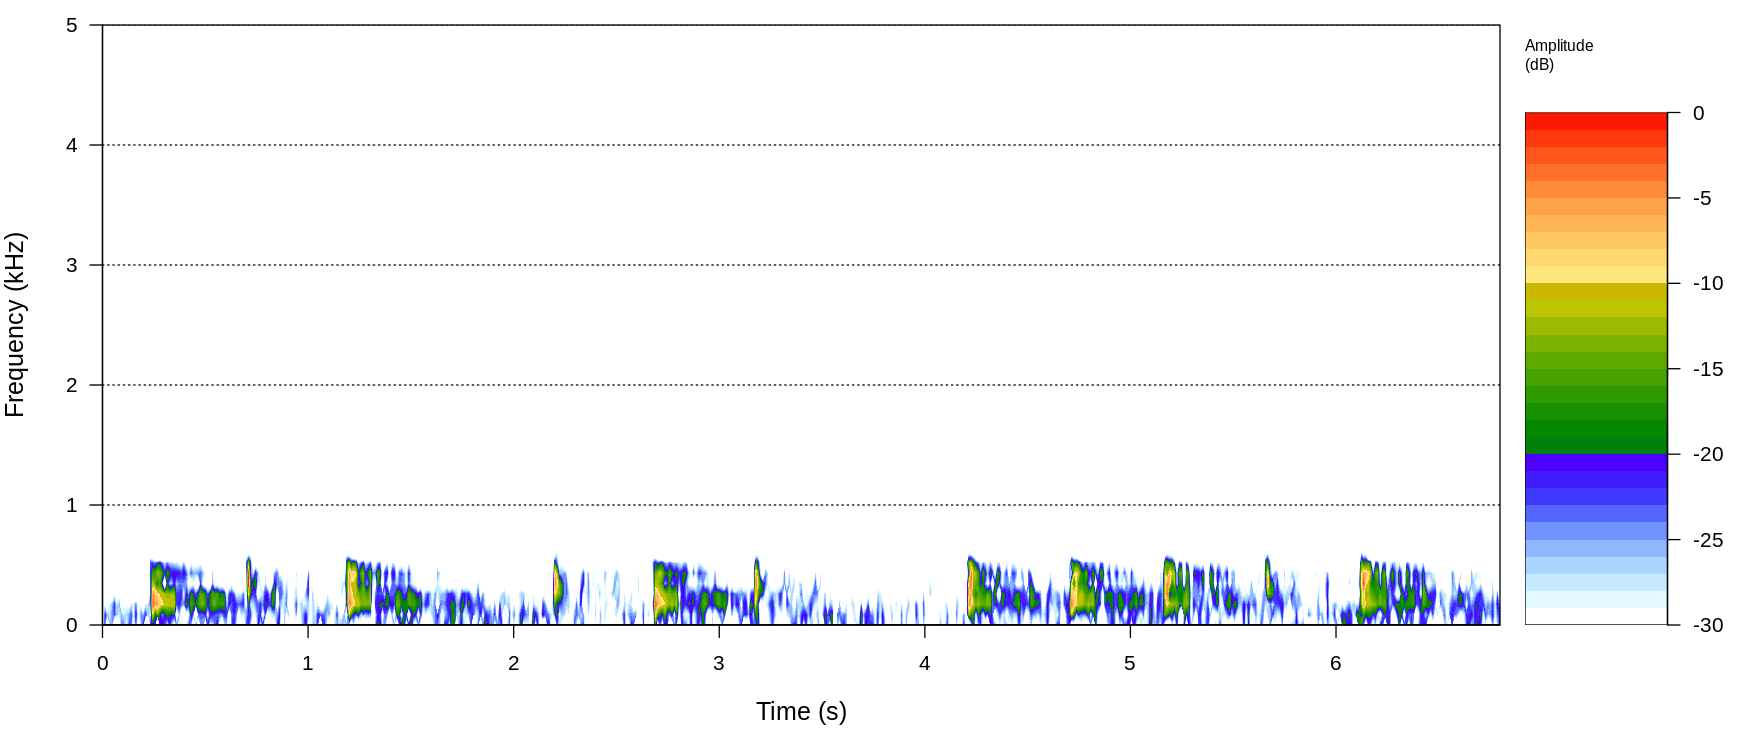

In [37]:
# low-pass filter; should get first drum only (low-pitched)
c3 <- ffilter(test0, f=44100, to = 550)
spectro(c3, f=44100, wl=512, flim = c(0,5))

We can then download these filtered datasets and play them out as a .wav file.

We find that the outputs don't sound that much different than our initial filters using the Butterworth filter. Similar patters that are found include: high-pass sounds airy, stringy; low-pass sounds muffled. But bot drums can still be heard.

In [38]:
drums.wave = Wave(c1, samp.rate = 44100, bit = 16)
drums.final <- normalize(drums.wave, unit = '16')
play(drums.final)
# save as wav file
writeWave(drums.final, "/tmp/c1.wav", extensible = TRUE)

drums.wave = Wave(c2, samp.rate = 44100, bit = 16)
drums.final <- normalize(drums.wave, unit = '16')
play(drums.final)
# save as wav file
writeWave(drums.final, "/tmp/c2.wav", extensible = TRUE)

drums.wave = Wave(c3, samp.rate = 44100, bit = 16)
drums.final <- normalize(drums.wave, unit = '16')
play(drums.final)
# save as wav file
writeWave(drums.final, "/tmp/c3.wav", extensible = TRUE)

Still not satisfied with output audio. Could we possibly try something else? Since every filter seems to keep both drums in somehow, is there somehow a way we can completely mute one drum from each high/low filter?

### The "last ditch effort":

We'll call this the last ditch effort, because everything we've tried so far wasn't able to completely filter out the other drum.



What we'll do here is create our own sort of filtering algorithm to silence the audio when the recording does not have the right volume of the drum being played.

We'll start by splitting the cadence into half-second sections. This is because drums can only play every half-second, at least in the recording that we have. Then, within each half-second, we will find the maximum volume that's played (via the absolute value of the amplitude of the note), and if it falls within a certain threshhold (above or below 0.5), we will choose to either filter it out or keep it.

In [39]:
# last ditch effort
test1 <- drums.reduced[150000:450000]
test2 <- drums.reduced[150000:450000]

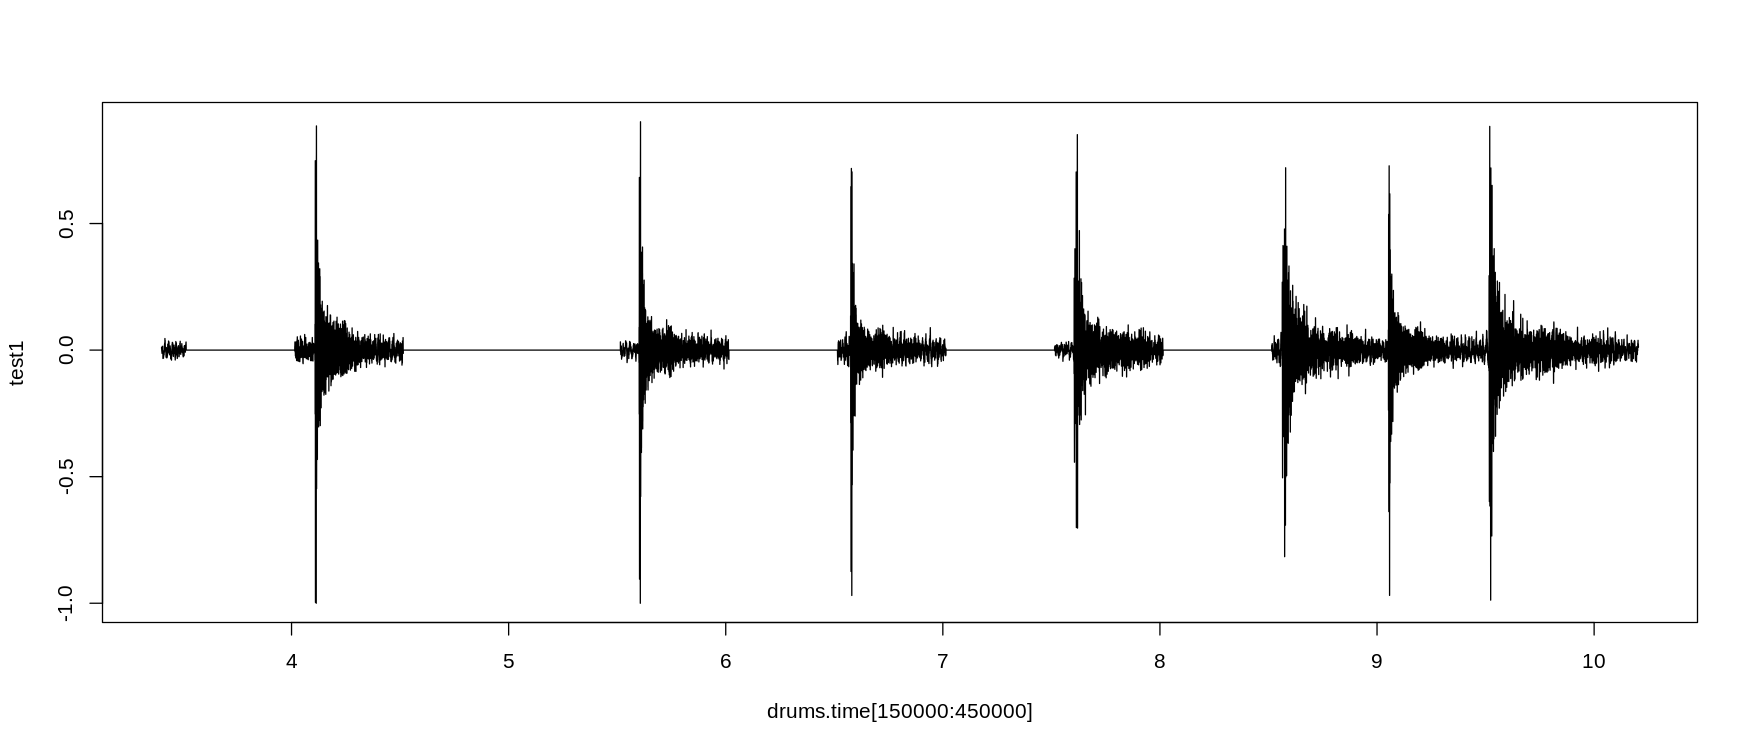

In [40]:
# 44100 sampling rate, so samples per second 
# in other words... 22050 samples every half second
for (i in 1:13) {
  # define the current "half second"
  half_sec = test1[((i-1)*22050+1+5000):(i*22050+1+5000)]

  # get the max dB of this second
  max_amp.time = which.max(abs(half_sec))
  max_amp.amp = abs(half_sec[max_amp.time])
  #print(max_amp.amp) # USE THIS TO SEE MAX AMPLITUDES PER HALF-SECOND

  # if the max dB here is less than or equal to the threshold of drum1...
  if (max_amp.amp < .7) {
    # remove everything in the current second
    for (pt in 1:length(half_sec)) {
      test1[((i-1)*22050+1+5000):(i*22050+1+5000)][pt] = 0
    }
  }
}

plot(drums.time[150000:450000],
  test1,
  type='l')

This is looking a lot cleaner! ...but cheatier... sort of. This is still using a "filtering" method of filtering out tea leaves through a certain algorithm, but it's based on the maximum amplitude per half-second. 

This does work, and can work for future runs, using the same code as long as notes are played no more than once every half-second. (This would be one note @ 128 bpm, for music-savvy people.)

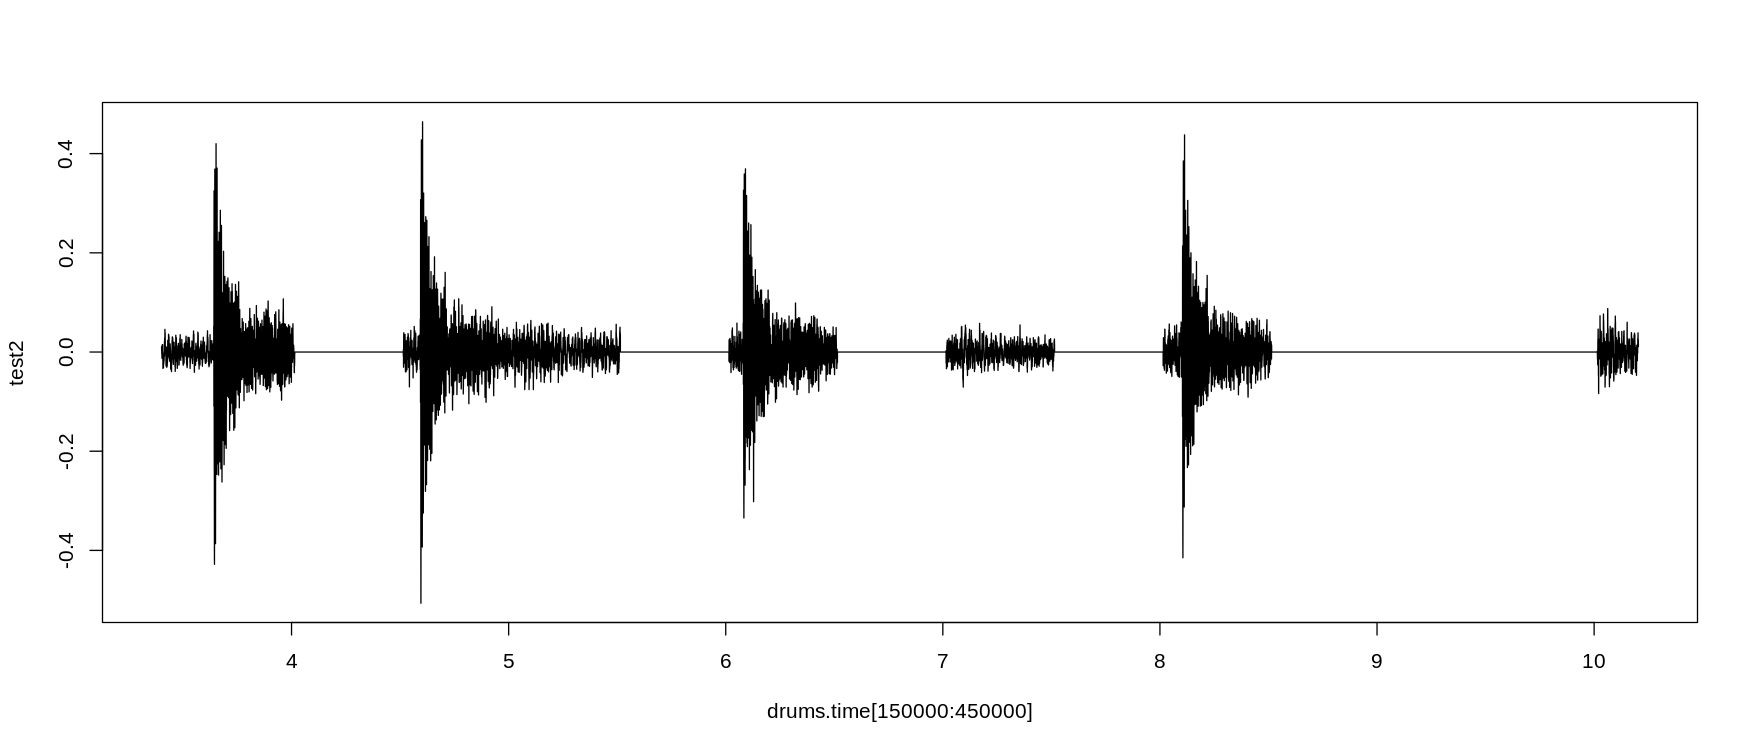

In [41]:
# try to filter out the higher drum2 (retain lower drum1)
for (i in 1:13) {
  # define the current "half second"
  half_sec = test2[((i-1)*22050+1+5000):(i*22050+1+5000)]

  # get the max dB of this second
  max_amp.time = which.max(abs(half_sec))
  max_amp.amp = abs(half_sec[max_amp.time])
  #print(max_amp.amp) # USE THIS TO SEE MAX AMPLITUDES PER HALF-SECOND

  # if the max dB here is greater than or equal to the threshold of drum2...
  if (max_amp.amp > .7) {
    # remove everything in the current second
    for (pt in 1:length(half_sec)) {
      test2[((i-1)*22050+1+5000):(i*22050+1+5000)][pt] = 0
    }
  }
}

plot(drums.time[150000:450000],
  test2,
  type='l')

When we try to have a low-pass, the high drum is completely silenced. But in the last measure, when the low drum and high drum play together, the note is removed or "filtered out" because the high drum dominates as it has a greater volume or amplitude.

We can then play it back and see how it sounds. It does sound a lot different than the previous filtering methods, and seemingly a lot more successful in eliminating the _other_ drum!

In [42]:
# save as test1.wav and test2.wav

drums.wave = Wave(test1, samp.rate = 44100, bit = 16)
drums.final <- normalize(drums.wave, unit = '16')
play(drums.final)
# save as wav file
writeWave(drums.final, "/tmp/test1.wav", extensible = TRUE)

drums.wave = Wave(test2, samp.rate = 44100, bit = 16)
drums.final <- normalize(drums.wave, unit = '16')
play(drums.final)
# save as wav file
writeWave(drums.final, "/tmp/test2.wav", extensible = TRUE)

## Conclusion

We tried several different methods of producing the intended results, and although none of them worked perfectly, we had success with each of them. With our butterworth filters, we were not able to utilize band pass and band stop filters the way we had hoped, as the results sounded too muffled. We had to resort to using low and high pass filters with a middleground cutoff, which had some mild success. Drum 2 could be mostly filtered out of drum 1's file, however drum 1 could not really be filtered out of drum 2's file. This is because the drums have a range of frequencies that overlap, meaning that it would not be possible to completely cut out either of the drums without sacrificing both. We were able to show the differences between the two drums in our frequency over time graphs, however when listening to the recordings, we hear that only some of the sound was filtered out, resulting in recordings similar to the butterworth ones. Finally, when analyzing the sound files at half-second intervals, we were able to cut out any non-overlapping drum beats, but we were limited in what we could do, as it would not be possible to handle simultaneous beats. In addition, we had to cut out all sound, so the recordings do sound choppy in comparison to the original sound files. Overall, despite not being able to achieve our end goal, we were still partially successful and learned a lot from our project.

## Sources

(1.3)&nbsp; Amplitude and Frequency. How Music Works. (n.d.). https://www.howmusicworks.org/103/Sound-and-Music/Amplitude-and-Frequency#:~:text=There%20are%20two%20main%20properties,how%20loud%20the%20sound%20is.&amp;text=Frequency%20is%20measured%20as%20the,that%20occur%20in%20one%20second. 

butterworth.wge: Perform Butterworth Filter. RDocumentation. (n.d.).
   https://www.rdocumentation.org/packages/tswge/versions/1.0.0/topics/butterworth.wge. 

Physics Tutorial: Pitch and Frequency. The Physics Classroom. (n.d.). https://www.physicsclassroom.com/class/sound/Lesson-2/Pitch-and-Frequency. 

seewave package. RDocumentation. (2020, May 28). https://www.rdocumentation.org/packages/seewave/versions/2.1.6. 

Sueur, J. (2020, May 28). Package 'seewave'. CRAN. https://cran.r-project.org/web/packages/seewave/seewave.pdf